In [1]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optimizer
import torch
from torch.utils.data import Dataset,DataLoader
from matplotlib import pyplot as plt
import numpy as np
import random

In [2]:
class ChannelAttention(nn.Module):
    def __init__(self, in_planes, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)#
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        self.fc1   = nn.Conv1d(in_planes, in_planes // 16, 1, bias=False)
        self.relu1 = nn.ReLU()
        self.fc2   = nn.Conv1d(in_planes // 16, in_planes, 1, bias=False)

        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu1(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu1(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)
    
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()

        assert kernel_size in (3, 7), 'kernel size must be 3 or 7'
        padding = 3 if kernel_size == 7 else 1

        self.conv1 = nn.Conv1d(2, 1, kernel_size, padding=padding, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

In [3]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.01)
        m.bias.data.fill_(0)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.01)
        m.bias.data.fill_(0)



class MyModel(nn.Module):
    def __init__(self):
        super(MyModel,self).__init__()
        self.inplanes = 32
        self.dilation = 1
        self.conv1 = nn.Conv1d(in_channels=1,  out_channels=16, kernel_size=5, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=5, stride=2, padding=0)
        self.pool = nn.MaxPool1d(2,2)
        self.ca1 = ChannelAttention(self.inplanes)
        self.sa1 = SpatialAttention()
        self.fc1 = nn.Linear(in_features=4064,out_features=1024)
        self.fc2 = nn.Linear(in_features=1024, out_features=512)
        self.drop = nn.Dropout(0.25)
        self.fc3 = nn.Linear(in_features=512, out_features=4)
        
        self.apply(weights_init)
        
    def forward(self,x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.ca1(x)*x
        x = self.sa1(x)*x
        x = x.flatten(start_dim=1)
        x = self.drop(x)
        
        x1 = F.relu(self.fc1(x))
        x2 = self.fc2(x1)
        x3 = self.drop(x2)
        x4 = self.fc3(x3)
        return x2,x4


In [4]:
file_path = "./datas/"
train_X = np.load(file_path+"train_origin/x_train.npy")
train_Y = np.load(file_path+"train_origin/y_train.npy").reshape(-1,1)
test_X = np.load(file_path+"test_origin/x_test.npy")
test_Y = np.load(file_path+"test_origin/y_test.npy").reshape(-1,1)
print(train_X.shape)
print(train_Y.shape)
print(train_X.shape[0])

(8000, 2048)
(8000, 1)
8000


In [5]:
class MyDataset(Dataset):
    def __init__(self, X, Y):
        self.data_x = torch.FloatTensor(X, )
        self.data_y = torch.FloatTensor(Y, )
        self.len = X.shape[0]
        pass
   
    def __getitem__(self, index):
        return self.data_x[index],self.data_y[index]
 
    def __len__(self):
        return self.len
    pass

In [6]:
# 设置种子
def setup_seed(seed):
    torch.manual_seed(seed) 
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed) 
    np.random.seed(seed) 
    random.seed(seed)
    torch.backends.cudnn.deterministic = True # if benchmark=True, deterministic will be False
    torch.backends.cudnn.enabled = False
    torch.backends.cudnn.benchmark = False
    #torch.backends.cudnn.benchmark = True #for accelerating the running
    
def _init_fn(worker_id):
    random.seed(10 + worker_id)
    np.random.seed(10 + worker_id)
    torch.manual_seed(10 + worker_id)
    torch.cuda.manual_seed(10 + worker_id)
    torch.cuda.manual_seed_all(10 + worker_id)


setup_seed(3490)

In [7]:
batch_size = 64

train_data = MyDataset(X=train_X, Y=train_Y)
# train_dataloader = DataLoader(train_data,batch_size=batch_size,shuffle=True,drop_last=True)
train_dataloader = DataLoader(train_data,                        
                    batch_size=batch_size,     
                    shuffle=True,    
                    drop_last=True, 
                    worker_init_fn=_init_fn) 

Net = MyModel()


criterion_loss = nn.CrossEntropyLoss()
opt = optimizer.Adam(Net.parameters(), lr=1e-4) 

In [8]:
epochs = 10
Loss_list = []
correct_list = []
for epoch in range(epochs):
    correct = 0
    running_loss = 0
    for i,data in enumerate(train_dataloader,0):
        train_x,train_y = data
        print(train_x,train_y)
        train_x = train_x.unsqueeze(dim=1) 
        train_y = train_y.squeeze().long() 
        _,outputs = Net(train_x)  
        loss = criterion_loss(outputs,train_y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        predicted = torch.max(outputs.data, 1)[1] 
#         y = torch.max(train_y.data, 1)[1]
        running_loss += loss.item()
        correct += (predicted == train_y).sum()
    Loss_list.append(running_loss / train_X.shape[0])
    correct_list.append(correct / train_X.shape[0])

tensor([[-7.1071, -4.6257, -2.8796,  ...,  0.8271,  1.5930,  1.1028],
        [-3.1859, -1.8074,  0.1532,  ...,  1.5930,  0.1838,  0.1838],
        [ 0.2757,  1.2254,  0.1838,  ...,  0.9803,  1.7768,  1.4704],
        ...,
        [-8.4550, -7.0152, -5.7592,  ..., -2.4507, -2.6652, -0.8578],
        [ 9.1902, 11.7941,  6.1574,  ..., -1.3785,  2.0525,  1.8380],
        [-0.3982,  1.5930,  0.2451,  ..., -1.2866, -0.0306,  1.3479]]) tensor([[1.],
        [1.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
      

        [  0.5820,   0.4901,  -0.0613,  ...,   0.9803,   0.7965,  -0.1532]]) tensor([[3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [0.],
        [0.]])
tensor([[-1.8687, -2.5120,

tensor([[  0.3676,  -0.7046,  -0.8578,  ...,   1.8687,  -1.1641,  -2.7571],
        [-10.8751, -19.4219, -20.2797,  ...,   1.0722,   3.6148,   4.9321],
        [  0.0000,  -1.3785,  -0.2144,  ...,  -0.9497,  -1.2560,  -0.4289],
        ...,
        [-16.6036, -12.0698,   0.8271,  ...,   7.9648,  15.8378,  10.5687],
        [  1.8074,   0.2144,  -0.6739,  ...,   1.9299,   0.2144,  -1.4092],
        [  0.0306,   2.6039,   1.4092,  ...,  -2.4201,  -2.3588,  -0.6739]]) tensor([[3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [3.],
        [3.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.]

tensor([[ -8.8839, -23.5269, -11.6715,  ...,  -1.2254,  -4.5032,  -1.7461],
        [ -0.3676,  -1.0416,  -2.1444,  ..., -35.6886,  -5.4835,  50.1478],
        [ -2.1444,  -1.0109,  -5.2078,  ...,  -1.4704,  -3.1553,  -4.4419],
        ...,
        [ -7.2603,  -2.3895,   2.9102,  ...,  -0.4595,  -1.4398,   0.6433],
        [-19.9427, -26.3759,  -1.6236,  ...,   3.4310,   1.9606,  -1.1641],
        [ -5.1771,  -8.8839, -13.0501,  ...,   2.8490,   0.8271,  -3.1247]]) tensor([[1.],
        [1.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.]

tensor([[-1.7768, -0.2451,  2.0831,  ..., -1.4704, -2.0218,  0.7965],
        [30.1438, 27.3255, 17.8596,  ..., -0.1225,  1.6236,  3.0021],
        [-1.2254, -1.3173, -1.6542,  ...,  2.2669,  1.3479, -1.1947],
        ...,
        [-0.8884, -0.8271, -0.1532,  ..., -1.2866, -2.2975, -1.0722],
        [ 1.1641,  0.9190,  0.2757,  ...,  0.4289,  0.9803,  1.7768],
        [-0.9190, -0.4289,  0.7965,  ..., -1.1335,  2.1750,  1.1335]]) tensor([[0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [3.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
      

tensor([[ -3.1553,   2.3282,   1.8380,  ...,   1.3785,  -2.3282,  -3.0634],
        [ -0.9497,   1.1028,   2.4814,  ...,   9.1902,  11.9473,  10.1092],
        [  3.0328,  -0.0306,  -0.6739,  ...,   5.7286,   3.5842,   1.1028],
        ...,
        [ -0.9190,   1.0109,   0.6433,  ...,   1.6542,   1.8380,  -0.9497],
        [-17.0019, -14.3061, -13.1420,  ...,  -4.2888,  -1.2254,   0.9497],
        [  1.6849,  -0.1838,  -0.9803,  ...,  -1.3785,  -2.4507,  -1.2254]]) tensor([[1.],
        [2.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]

tensor([[  0.4289,   3.4616,   3.7067,  ...,  -1.8687,  -0.6739,  -5.4835],
        [-18.8093, -21.8114, -21.3213,  ...,  -1.8074,   1.7768,   6.5250],
        [ -0.2451,   0.2757,   0.7352,  ...,  -1.6849,   0.3063,   1.0109],
        ...,
        [  5.7898,   1.5930,  -1.8993,  ...,  -3.2166,  -3.3085,  -5.8511],
        [  0.1532,   0.0919,   0.5208,  ...,   2.5426,   2.3282,  -0.5208],
        [-18.4723,  -8.4243,  -1.9912,  ...,  -2.7571,  -3.2778,  -0.9497]]) tensor([[2.],
        [1.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [2.],
        [3.],
        [1.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.]

tensor([[  1.8074,  -0.0306,  -1.6849,  ...,   1.8993,   0.9190,   0.6127],
        [  0.3063,   3.7067,  -7.3828,  ...,  -5.1159,  -3.8905,  -2.0218],
        [  5.9430,   9.6497,  12.3761,  ...,   5.0240,  -1.5623,  -2.4507],
        ...,
        [ -1.6849,  -1.5011,   0.8884,  ...,  -0.7352,  -0.9803,  -1.6236],
        [-10.2011,  -0.9190,   0.5208,  ...,  -0.4901,  -1.1641,  -3.3697],
        [  2.0218,  -0.7658,  -2.8796,  ..., -25.0280, -14.1223, -10.7525]]) tensor([[3.],
        [2.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.]

tensor([[ 3.5842,  2.2975,  2.6345,  ...,  5.0240,  7.0765,  5.1159],
        [ 0.4901, -0.6127, -0.3063,  ..., -1.0722,  0.0306,  1.1335],
        [ 1.3479, -0.1838, -1.7461,  ...,  0.4901,  0.1532, -0.3370],
        ...,
        [-6.0655,  3.3697,  7.3522,  ..., 10.0479,  2.6958, -6.4944],
        [ 0.0000,  7.6891,  4.8095,  ...,  1.5930,  1.8380,  0.6739],
        [-2.7571, -2.3895, -0.7352,  ...,  3.0021,  1.5011, -2.6345]]) tensor([[1.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [1.],
        [2.],
        [3.],
        [3.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [2.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
      

tensor([[-35.1065, -33.3604,   7.0152,  ...,   0.2144,  -4.8095, -22.5772],
        [  2.0218,   1.5623,  -1.6849,  ...,  -8.9145,  -5.4835,  -1.5011],
        [ -1.8380,   1.1335,   0.7352,  ...,  -2.9715,  -1.3173,   1.9912],
        ...,
        [ -2.1137, -10.2930, -12.5906,  ...,  -1.5317,  -1.3785,   1.3173],
        [  1.6236,   0.3676,  -2.2363,  ...,  -1.5011,  -2.9715,  -3.4310],
        [ -1.5623,  -0.6739,   0.6739,  ...,   0.9803,   0.2144,  -2.3282]]) tensor([[1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.]

tensor([[-4.3194,  5.5754,  3.0328,  ...,  9.9254,  8.5162,  4.0131],
        [ 1.0416,  0.4595,  0.0306,  ..., -0.2144,  0.7046, -0.7352],
        [-0.7352,  0.0613,  1.2560,  ..., -1.1947, -0.0306,  2.0218],
        ...,
        [-0.6127,  1.2254,  0.9803,  ..., -0.5514,  0.6433,  0.8884],
        [ 0.9190,  1.8074,  0.1532,  ..., -0.5514,  0.9803, -1.2866],
        [ 1.6849, -1.6236, -0.8884,  ..., -0.7046, -2.0218,  0.6433]]) tensor([[1.],
        [3.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [2.],
      

tensor([[ 0.0919,  2.2363,  1.5317,  ..., -0.9190,  0.7658, -0.1225],
        [-0.9803,  1.1028,  0.2757,  ...,  0.1532, -0.8578, -2.4507],
        [ 0.1838, -1.1947,  0.8578,  ..., -2.2975, -0.6739,  2.2056],
        ...,
        [-0.9190, -0.1225, -1.0722,  ..., -2.2363, -0.7658,  1.8993],
        [-8.5162, -5.7286, -4.2888,  ...,  1.6236,  6.0043,  5.2078],
        [-0.0919, -3.0634, -4.3500,  ..., -3.1553, -5.8511, -6.0043]]) tensor([[3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [3.],
        [2.],
        [3.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
      

tensor([[ -1.4398,  -2.7571,  -2.9715,  ...,  -2.6039,  -7.7504, -10.6300],
        [ -0.9497,  -1.1947,  -1.3173,  ...,  -0.0306,  -0.5820,   1.0416],
        [ 11.8247,  18.3191,  21.3519,  ...,   2.5120,  -0.4595,  -1.4704],
        ...,
        [ 17.3082,   8.8839,  11.6103,  ...,   0.6127,   5.0240,   7.0765],
        [  5.4222,  -0.5820,  -2.1750,  ..., -13.3564,  -7.3522,  -5.4835],
        [ -0.3063,  -0.1838,   0.3370,  ...,   1.1641,  -0.5514,  -0.8271]]) tensor([[2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.]

tensor([[ -0.2451,  -4.3500,  -9.3127,  ...,  17.0938,  18.5642,  12.8050],
        [-14.1223, -21.4132, -24.2621,  ...,  -4.1050,  -4.0437,  -0.3676],
        [  0.8578,  13.0194,  15.5927,  ...,  -1.4092,  -0.7352,   2.9715],
        ...,
        [ -2.2975,  -2.0218,  -1.3785,  ...,  -3.0634, -19.7283, -26.4065],
        [ -0.1838,  -1.3173,  -0.8271,  ...,  -1.4704,  -0.6433,   1.1947],
        [ -3.0021,  -4.4113,  -1.2560,  ...,   2.2975,  -0.5208,  -0.9803]]) tensor([[2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [3.],
        [3.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.]

tensor([[  1.1335,   1.0109,  -1.8993,  ...,  -1.6849,  -1.1947,  -0.1838],
        [  1.1641,   0.9190,   0.2757,  ...,   0.4289,   0.9803,   1.7768],
        [ -1.0416,  12.2842,  12.4374,  ...,   4.6870,  -2.2363,  -4.6870],
        ...,
        [ -0.4595,   0.9190,   0.8271,  ...,   1.5930,  -1.4704,  -2.0525],
        [  4.7176,   2.3588,  -2.3282,  ...,   1.0722,   1.9299,   1.6542],
        [ -1.6849,  -3.8292,  -2.0831,  ...,  17.1857,  -8.9758, -29.6537]]) tensor([[0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.]

tensor([[ -0.0613,  -2.4201,  -9.8335,  ...,  -2.8183,  -0.3063,   2.2056],
        [  1.1335,   0.9803,   1.2254,  ...,   1.2866,   1.8993,   0.3370],
        [  0.0919,  -3.8599,  -4.1050,  ...,   0.0919,   1.1947,   0.0306],
        ...,
        [  3.1859,   4.9933,   3.8292,  ...,  -9.8029, -13.4483,  -0.8884],
        [ -0.5514,  -1.3479,   0.2757,  ...,  -1.0109,   1.1947,   0.3982],
        [  3.8905,   2.6345,  -1.7461,  ...,  -0.1532,   2.6345,   1.2866]]) tensor([[2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [1.],
        [3.]

tensor([[  0.5208,   1.0109,  -0.4595,  ...,  -4.5645,  -9.6803, -14.4899],
        [  0.5514,  -0.3982,  -1.1641,  ...,  -0.7658,  -1.8380,  -1.1641],
        [ -0.7658,   1.8380,   1.7768,  ...,   1.7155,  -0.1225,   0.1225],
        ...,
        [  0.8884,   1.9912,   0.9497,  ...,  12.8356,   9.9560,   6.7701],
        [ -0.3982,   0.0919,  -0.0306,  ...,   0.0613,   0.9497,   2.5426],
        [ -1.9912,   0.4289,   1.5011,  ...,  -1.6849,   1.8380,   0.0000]]) tensor([[2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.]

tensor([[-18.5029, -30.2358, -20.2491,  ...,   2.0218,   3.7373,   2.9715],
        [  0.9190,   1.3785,   0.3063,  ...,  -1.2560,   3.1247,   1.5011],
        [  1.4398,   2.9102,   1.4398,  ...,   0.1225,  -0.4595,  -0.8271],
        ...,
        [ -5.6673,   9.9254,  17.5839,  ...,   1.2560,   4.1662,  -0.7658],
        [  0.6739,   3.0021,   1.8380,  ...,  -1.6542,  -1.4704,  -0.7965],
        [ 14.4592, -19.1462, -18.9012,  ...,  -1.7155,  -5.4835,  -6.6476]]) tensor([[2.],
        [0.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [0.],
        [0.],
        [2.],
        [2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [0.],
        [2.]

tensor([[ -3.3085,  -5.2997,  -2.4201,  ...,  24.2927,  16.9712,  -8.0261],
        [  2.1137,   2.5733,   2.3588,  ...,   1.9299,  -1.4092,  -2.2363],
        [ -0.9190,  -1.2866,   0.6433,  ...,   0.0613,   0.0919,   0.1838],
        ...,
        [ -1.0416,   0.0919,   2.9102,  ...,   1.5011,   3.5229,   2.6652],
        [ -2.1750, -19.1769,   3.2166,  ...,  -1.7155,  -4.5645,  -6.3106],
        [ -5.4528,   3.5535,   5.3609,  ...,   1.2560,  -3.0634,  -3.5229]]) tensor([[1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [0.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.]

tensor([[  1.7768,   4.3807,   4.3500,  ...,  -4.8708,  -7.7810,  -4.0437],
        [  0.1225,   2.4201,   2.3282,  ...,   1.2866,   1.3785,  -0.5208],
        [  2.7877,  11.2427, -10.5381,  ...,  -3.4004,  -3.2166,  -1.2866],
        ...,
        [ -4.3807,  -7.3215, -13.0501,  ...,  -1.4704,   3.4616,   4.2581],
        [  7.4441,   4.2275,   3.7067,  ...,  -2.7264,  -0.8884,   2.2975],
        [  0.5208,  -0.2757,  -1.2254,  ...,   0.8884,   0.0613,  -1.6542]]) tensor([[1.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.]

tensor([[-0.8884,  1.0416,  0.6739,  ...,  0.8271,  1.1335, -1.2560],
        [-2.5426, -0.8884, -0.9803,  ...,  0.1532,  0.8578,  0.9497],
        [ 1.5623, -0.8271, -0.8271,  ..., -1.1947,  0.9803,  2.2669],
        ...,
        [-1.4092, -1.8687, -0.2757,  ..., -1.2560, -1.4398,  0.5514],
        [ 3.0940,  0.6433, -1.7768,  ...,  1.3479,  1.4398,  0.0919],
        [-1.5623,  0.5208,  0.2451,  ..., -1.4092, -1.4398, -1.0722]]) tensor([[0.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
      

tensor([[  6.7395,  10.8138,   6.5863,  ...,   4.2888,   1.9912,   1.8380],
        [  1.3785,  -0.4289,  -0.7046,  ...,  -0.3370,  -0.1532,  -0.8271],
        [  9.7416,  17.0631,  17.3388,  ...,   0.6739,   2.3282,  -0.7046],
        ...,
        [ -5.0240,  -7.0152,  -8.5162,  ...,  -2.0525,   0.4595,   1.9912],
        [-14.9800,  -2.2363,  -7.6891,  ...,  -0.1225,   2.3895,  10.6300],
        [ -4.5951,   1.8687,   4.7789,  ...,   2.8796,  -0.2144,  -2.3282]]) tensor([[1.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [3.],
        [1.],
        [2.]

tensor([[-2.2056, -2.1444, -0.8271,  ..., -0.1838, -0.4901,  2.2669],
        [-1.8687, -1.0416, -1.0416,  ...,  0.1225, -0.5514, -0.4595],
        [-1.7461, -2.9715, -4.5645,  ..., -0.8884, 11.6715, 14.2142],
        ...,
        [-0.8884,  2.6345,  2.6958,  ..., -1.4092, -0.4289,  0.4289],
        [-0.3676, -2.2363, -1.5623,  ...,  1.2254,  1.3479, -0.7046],
        [-1.2866,  1.4398,  1.7461,  ..., -4.3194, -2.4201,  2.9715]]) tensor([[3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [2.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
      

tensor([[-9.4353, -8.7307, -7.4441,  ...,  0.6127,  8.5775,  6.0349],
        [ 0.1838, -0.4595, -0.1225,  ...,  0.6127,  1.1335,  1.2254],
        [ 0.9190, -0.1532, -0.3982,  ..., -1.8993,  1.1028,  1.8380],
        ...,
        [ 2.6345, -0.3063, -2.7877,  ..., -0.3370, -1.4704, -1.1947],
        [-4.3194, -1.9299,  2.0218,  ...,  0.6433,  0.4595,  0.0919],
        [ 0.6433,  1.2254,  0.5514,  ...,  1.2254,  0.0306, -1.0722]]) tensor([[2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [0.],
        [3.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
      

tensor([[ 0.1532,  0.4289,  1.7461,  ...,  1.5317,  3.9211, -0.8271],
        [-0.9803, -1.8993,  0.0919,  ..., -1.9606, -1.4398,  0.2757],
        [-0.0306, -1.1641, -0.8578,  ..., -0.2451, -0.6739, -1.5930],
        ...,
        [-1.0722,  0.1532,  1.6542,  ...,  0.0306,  1.9299,  1.9606],
        [ 0.8884,  0.9803, -1.0109,  ...,  0.2451,  1.1028,  1.5317],
        [ 2.2363, -3.1553, -2.1750,  ..., -1.1335,  0.9190, -0.6433]]) tensor([[3.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
      

tensor([[ -6.0349,  -1.0416,   0.3063,  ...,  -1.5623,  -1.1947,  -3.0328],
        [ 10.5075,   3.3697,  -2.3895,  ...,  -2.5120,  -2.9102,  -2.2975],
        [ -8.3937, -14.1529, -15.5008,  ...,  -2.5426,  -0.3982,   0.3063],
        ...,
        [-13.3258, -10.8444, -12.9582,  ...,  10.9057,  33.4829,  14.4592],
        [ -0.3676,   2.2363,   1.8380,  ...,   7.5053,   6.9233,   4.7176],
        [  0.2757,   2.2975,   1.1028,  ...,  -0.7046,  -1.1947,   0.0000]]) tensor([[1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.]

tensor([[  2.4201,   0.0306,  -2.4814,  ...,   0.2757,   0.2144,  -0.5820],
        [ -0.3676,   1.1335,   3.6148,  ...,  12.4374,  10.3543,  10.9057],
        [  0.3982,   0.0613,   0.3370,  ...,   1.9912,   2.4201,  -0.7658],
        ...,
        [  0.0613,  -0.9497,   1.0416,  ...,  -0.7046,  -0.9497,  -3.5842],
        [  1.5930,   0.6127,   1.5011,  ...,  -0.1838,  -0.0613,   1.5011],
        [-28.5202, -18.5948,  26.8966,  ...,  -0.2144,  -8.3324,  -7.7810]]) tensor([[3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [3.],
        [3.]

tensor([[ 0.5208,  1.3785,  2.6958,  ..., 30.3889, 16.5424, 17.7983],
        [ 1.1335,  1.5011,  0.9803,  ..., -0.6739, -1.0722,  0.7352],
        [-5.6673, -4.0743, -2.2363,  ..., 11.5490, 14.7962, 14.3367],
        ...,
        [-0.0306,  1.7768,  3.1553,  ...,  1.8993, -0.0919, -0.4595],
        [-0.0919, -2.1750, -0.5208,  ...,  1.5623,  1.3173, -0.7658],
        [-0.3370, -2.0831, -3.5229,  ...,  1.0109,  1.9912,  4.1969]]) tensor([[1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.],
        [2.],
      

tensor([[-5.3916, -5.1465, -0.1225,  ...,  2.2669, -1.4398, -2.4507],
        [-1.1947, -0.9497, -0.3063,  ..., -1.9606, -1.8380, -0.7658],
        [ 0.7965, -0.6433, -1.0722,  ..., -1.1641,  1.0416,  1.5623],
        ...,
        [ 2.6652,  1.8687, -1.5623,  ..., 16.8487,  6.8926, -1.9299],
        [ 2.3282,  0.3982, -0.7352,  ..., -1.0722, -2.1137,  1.5623],
        [ 0.4901, -0.0919,  0.1225,  ...,  0.3063, -1.2866, -0.5820]]) tensor([[2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
      

tensor([[ 6.0655,  5.6673,  1.5623,  ..., -0.6739, -1.6236,  1.3785],
        [ 1.5317,  4.4113,  0.9497,  ...,  0.9190, -1.2254, -0.4289],
        [-1.1947, -0.9190, -0.8884,  ...,  1.5930,  1.3173, -1.1947],
        ...,
        [ 4.1969,  1.6236, -2.7264,  ...,  1.0416,  0.3370,  0.1532],
        [ 9.0064,  3.3085,  3.7680,  ...,  2.6958,  1.5011,  1.1641],
        [-1.8380, -0.9190,  0.8578,  ...,  0.2451, -0.1532,  0.0919]]) tensor([[2.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
      

tensor([[  3.0634,   5.7592,   8.4856,  ...,  -3.5229,  -1.7155,   0.6433],
        [  0.4289,  -1.1641,  -0.8884,  ...,   0.9803,   0.2757,   1.4398],
        [  8.7307,   8.4550,   5.5754,  ...,  -2.1137,   0.3676,  -0.2144],
        ...,
        [  6.3412,   7.1684,   7.3522,  ..., -16.9406, -32.0432, -31.5224],
        [  0.9190,  -0.0613,  -1.1335,  ...,   0.1838,   0.8271,   1.5623],
        [ -3.9211,  -5.5448,  -3.1247,  ...,  -0.9190,   0.7046,   2.6345]]) tensor([[2.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.]

tensor([[ -2.9102,  -4.5032,  -3.3391,  ...,   4.3194,   3.7986,   0.1225],
        [  2.2363,   2.7877,   0.2757,  ...,   0.2451,   1.0109,   0.7046],
        [  2.5733,   0.3063,  -1.0416,  ...,  -0.3676,  -1.3479,  -1.7155],
        ...,
        [  0.1838,   5.6060,   7.8117,  ...,  -1.4092,  -1.9606,   0.5208],
        [  2.3895,  -0.1532,  -1.0416,  ...,  -2.5426,   2.1750,   2.2669],
        [  0.0306,  -3.5229, -13.2032,  ...,  -2.2975,  -3.5535,  -3.6454]]) tensor([[1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.]

tensor([[-13.2339,  -5.8511,   2.8796,  ...,   4.1356,   5.3609,   9.5272],
        [ 10.5687,  29.1023,  25.1199,  ...,   9.0064,   3.4310,   1.1335],
        [  0.0306,  -0.3982,  -1.0722,  ...,   0.4901,   1.8074,   0.0306],
        ...,
        [ -8.0567,  15.5314,  13.0501,  ...,  -2.0218,  -3.2166,  -2.9102],
        [ -0.1838,   2.6039,   1.4704,  ...,   0.3982,   0.0306,  -0.1225],
        [  1.8993,   1.0109,   0.0919,  ...,   1.1947,   0.8578,  -0.6433]]) tensor([[1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [2.],
        [1.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.]

tensor([[ 1.9912,  0.3676, -0.2757,  ..., -1.1335,  0.9497,  2.3588],
        [ 0.4289,  0.2451, -1.0109,  ..., -1.2560,  0.1838,  1.1028],
        [ 0.5514, -0.6739, -1.0416,  ..., -1.1335, -0.2757,  0.5514],
        ...,
        [ 0.2757,  2.5733,  1.3479,  ...,  1.1641, -0.4901,  0.5820],
        [-0.7352, -1.9912, -0.6433,  ..., -2.6652, -0.7965, -0.1838],
        [-5.9124, -8.3937, -7.0765,  ..., -3.4004,  2.9409,  4.2888]]) tensor([[3.],
        [0.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
      

tensor([[-0.8884,  0.5514,  0.5208,  ...,  1.0109,  0.1532, -0.8271],
        [ 1.3785,  1.4092,  0.4595,  ...,  0.4901, -1.0109,  0.2144],
        [ 0.4901, -1.9912, -3.0021,  ..., -1.0416, -0.7046,  1.0109],
        ...,
        [-0.2451,  0.0613, -2.8796,  ...,  2.8796,  3.3085,  4.7176],
        [ 4.3807,  2.6652, -0.3676,  ..., -3.0328, -0.5208,  2.6958],
        [-1.4704, -0.0306,  3.2166,  ...,  0.4595,  0.8884,  0.2451]]) tensor([[3.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [1.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [0.],
        [2.],
      

tensor([[ 0.2757, -1.1947, -1.0416,  ..., -1.0416,  0.7352,  0.7658],
        [-1.1028,  0.1225,  1.7768,  ..., -0.4595, -0.6433, -1.3173],
        [ 0.8884, -0.2451,  1.3479,  ..., -3.8292,  4.8402, 17.0325],
        ...,
        [-4.4113, -4.6870, -4.4726,  ..., -0.7046,  1.6542,  0.4595],
        [ 1.3785,  0.6739, -0.8578,  ...,  1.1947, -0.7965, -0.0919],
        [ 3.9518,  3.4310,  3.9824,  ..., -2.7264, -2.7877, -1.2560]]) tensor([[0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
      

tensor([[ 7.1071, 10.0173, 13.9997,  ..., -1.8074, -1.2866, -0.1838],
        [ 1.1641,  1.5623,  0.3982,  ..., -1.4398, -0.3982,  1.3479],
        [ 0.3063,  1.0722, -1.0109,  ...,  2.6345, -1.1028, -1.7461],
        ...,
        [ 1.2254, -0.3370, -0.2144,  ...,  2.1444,  0.7965, -0.0613],
        [-2.0218, -1.1641,  1.2866,  ...,  0.3370, -0.0613, -0.5820],
        [ 4.1662, -4.0131, -9.0677,  ...,  4.2581,  4.0437,  3.8599]]) tensor([[2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [3.],
        [3.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
      

tensor([[-3.4923, -1.3479, -1.1028,  ...,  6.6782,  5.4835,  4.4113],
        [-6.4638, -4.5951, -3.9824,  ...,  3.3085,  2.1750, -0.9803],
        [ 0.3370,  0.4289,  1.1641,  ..., -0.1838,  1.4092,  0.4289],
        ...,
        [ 2.1137, -0.1838, -2.1444,  ...,  0.3063, -0.5820,  0.3676],
        [-3.0021, -7.1071, -7.8117,  ...,  0.7046,  6.5863, 10.2624],
        [-2.8490, -4.1662, -6.9539,  ..., -0.4289,  1.3785,  1.1335]]) tensor([[2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
      

tensor([[  2.2363,   0.8578,  -0.7352,  ...,  -2.7571,   1.7768,   4.9933],
        [  0.0919,  -1.7461,  -0.1532,  ...,   0.5514,   0.4901,   0.1532],
        [ -1.9912,   0.3063,   1.2866,  ...,  -1.8380,   0.3370,   1.6542],
        ...,
        [  9.5272,  12.8969,  17.9821,  ...,  -5.3609,  -7.6891,  -8.3324],
        [  1.1335,  -1.5930,  -2.7571,  ...,  -3.2166,   0.3982,   3.6761],
        [ -6.1574,  -9.9560, -12.2536,  ...,  -1.2866,  -2.1137,  -0.6433]]) tensor([[2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [2.],
        [1.],
        [3.],
        [3.],
        [2.]

tensor([[  0.3982,   3.1247,   2.6652,  ...,  -7.9648,  -4.6257,  -3.3085],
        [ -1.2560,  -1.2560,   0.7965,  ...,  -3.1247,  -2.4814,   0.4901],
        [  2.7571,   1.5930,  -2.6958,  ...,  -7.7198, -11.3958, -10.4462],
        ...,
        [ -1.1947,  -0.8271,  -1.2254,  ...,   2.5426,   6.0043,   9.0370],
        [ -1.1947,   0.2451,   0.7658,  ...,  -1.3173,   1.6849,   3.4616],
        [ -1.5317,  -2.5426,  -6.3412,  ...,   1.0416,   1.8993,  -2.9102]]) tensor([[2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [0.]

tensor([[  0.3676,   2.5120,   2.7877,  ...,  -1.9912,  -2.0218,   0.9497],
        [ -3.5535,  -4.7483, -11.7941,  ...,   1.1947,   1.5317,   1.5930],
        [ -1.3479,  -0.8884,   1.9606,  ...,  -2.7571,   0.3676,   7.8423],
        ...,
        [  0.8271,   0.1532,  -1.6236,  ...,   1.4398,   0.0000,  -2.0525],
        [  1.6849,   0.2451,  -1.0416,  ...,  -0.5514,  -0.3370,   0.3370],
        [ -8.5162,  -5.7286,  -4.2888,  ...,   1.6236,   6.0043,   5.2078]]) tensor([[0.],
        [2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]

tensor([[  4.9321,   9.1289,   7.8423,  ..., -13.1420,   5.2997,  19.1156],
        [  0.7352,   0.3370,   0.8578,  ...,   3.3085,   4.0437,   1.7155],
        [ -1.4704,  -2.3588,  -0.7352,  ...,   1.0416,   3.4310,   1.5317],
        ...,
        [ -0.3370,  -1.1028,  -0.3370,  ...,  -0.7352,  -2.1750,  -0.5820],
        [  2.1137,   2.2975,   1.3173,  ...,   1.1028,   2.1137,  -0.8884],
        [ -0.7965,  -0.6127,  -2.1137,  ...,   2.4507,   0.3676,  -1.7461]]) tensor([[2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.]

tensor([[ -5.3609, -11.2733, -18.3804,  ...,  -1.6849,  -5.4528,  -4.1050],
        [  2.9409,   0.4289,  -1.8993,  ...,  36.5157,  48.9225,  63.7493],
        [ 13.9078,   3.2166,   3.5535,  ...,   0.7352,  -1.0109,  -0.4289],
        ...,
        [  7.4441, -14.2448, -17.1857,  ...,   8.2712,   3.9518,  -3.1247],
        [ -8.5162,  -8.3631,  -4.4113,  ...,  -0.2144,   0.9497,   2.5426],
        [ -0.0919,  -0.3676,   0.3063,  ...,  -0.7965,   1.0722,  -0.1225]]) tensor([[2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [0.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.]

tensor([[ -7.3215,   1.7461,   3.1247,  ...,   5.2384,   5.9736,   2.8796],
        [  1.1641,  -0.4901,  -1.1335,  ...,   1.1947,  -1.1641,   0.2451],
        [  0.9497,  -0.9803,  -0.6739,  ...,   1.3479,  -1.4092,  -0.9497],
        ...,
        [ -0.9497,   0.9190,   1.8074,  ...,   1.7461,  -0.2757,  -1.9606],
        [ -0.9190,  -0.1225,  -1.0722,  ...,  -2.2363,  -0.7658,   1.8993],
        [  1.1947,  -2.5733,  -4.1969,  ..., -10.7832,  -7.5972,  -6.4638]]) tensor([[1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.]

tensor([[ -0.3676,   0.8271,  -0.0919,  ...,   0.3676,   0.1532,   0.3676],
        [-15.2864, -11.5490,  -6.4944,  ...,  -1.0722,   0.7965,   2.0831],
        [ 12.1004,  14.3673,   9.5578,  ...,   1.2866,   3.4923,   1.7768],
        ...,
        [  2.0525,   1.0416,  -0.0613,  ...,   0.2757,  -0.5514,   1.3173],
        [  2.9102,   4.1356,   4.2275,  ...,  -2.7877,  -3.4004,   1.4092],
        [ -1.9912,  -0.4289,  -1.0722,  ...,   1.6236,   1.5011,   0.0000]]) tensor([[0.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [3.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [1.],
        [3.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.]

tensor([[  0.5208,  -1.3173,  -0.7658,  ...,  -1.4704,   0.0000,   2.1750],
        [  2.2363,  -0.2757,  -0.8271,  ...,  -0.6127,  -2.8183,  -1.1335],
        [ -0.5208,  -1.1641,  -0.1838,  ...,  -0.0919,   0.0000,   0.3370],
        ...,
        [ -6.1268,  -3.0940,   1.3479,  ...,   7.2909,   6.8620,   4.4113],
        [ -2.7264,   0.0919,   2.8183,  ...,  -1.5930,  -0.7352,   0.7046],
        [-22.2403, -30.0519, -18.2885,  ...,  -0.8578,  -1.8687,   1.4398]]) tensor([[3.],
        [3.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [0.]

tensor([[ -9.1902,  15.9603,  34.0650,  ..., -14.3367,  -6.2493,   1.8380],
        [ -0.3982,   1.9299,   0.0919,  ..., -10.9976, -11.0895, -11.2733],
        [  1.2254,  -1.7155,  -4.1969,  ...,  -2.2975,  -2.6039,  -2.6652],
        ...,
        [  1.4704,   0.0919,   1.8074,  ...,  -1.7461,  -5.7898,  -5.7286],
        [  0.8578,  -0.6433,  -2.1137,  ...,   2.7264,   1.3479,  -3.0021],
        [ 35.8111,  56.3665,  24.9054,  ...,  15.8071,   3.0021,   1.7461]]) tensor([[1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.]

tensor([[ -1.1947,   0.2451,   0.7658,  ...,  -1.3173,   1.6849,   3.4616],
        [  1.5011,  -1.3785,  -2.0525,  ...,  -0.4289,   0.4901,   2.1444],
        [  4.9627,  -0.0613,  -1.1641,  ...,  11.4878,  -2.3895,  -1.9606],
        ...,
        [ -4.7176,  -8.0874,  -7.6585,  ...,  21.9646,   2.7571, -21.8114],
        [ -1.3173,  -4.1050,  -5.0240,  ...,  -0.6433,  -3.4923,  -7.5666],
        [  5.0546,   0.6127,   0.9497,  ...,   4.1356,   3.5229,  -0.1225]]) tensor([[1.],
        [3.],
        [1.],
        [0.],
        [3.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.]

tensor([[ 1.2560, -2.6039, -2.1137,  ..., -1.7768, -1.2254,  1.4704],
        [ 0.0613,  1.5930,  0.8578,  ...,  0.0000,  0.9190,  1.5930],
        [ 4.7789,  4.6564, 10.5381,  ...,  0.3982, -3.8292,  1.3785],
        ...,
        [-2.5733, -1.0722,  0.2451,  ..., -1.0109,  0.9803,  1.1335],
        [-0.1838,  1.6236,  0.6127,  ..., -1.7461,  0.2451,  2.1137],
        [-0.9803, -1.8993,  0.0919,  ..., -1.9606, -1.4398,  0.2757]]) tensor([[3.],
        [3.],
        [1.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [3.],
      

tensor([[ 0.6127,  2.7571,  1.5317,  ..., -0.6739, -1.7155, -0.8578],
        [ 1.0416, -0.5208,  0.2451,  ..., -3.8599, -3.6454,  0.5514],
        [-2.1444,  1.2254,  1.9299,  ...,  0.9803,  1.8380, -0.0613],
        ...,
        [-0.2451, -0.0306, -0.3063,  ...,  1.0109, -0.7352, -2.1750],
        [-1.4398,  0.6739,  2.5120,  ...,  1.3173, -0.5208, -0.6127],
        [ 0.1532,  0.5208, -0.8578,  ..., -0.2451, -0.4901, -0.3676]]) tensor([[0.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
      

tensor([[  3.4923,   5.7898,   6.5557,  ...,   2.3895,   0.2757,  -0.2144],
        [ -0.3063,   2.1137,   2.2975,  ...,   0.1225,  -0.0306,  -0.7352],
        [  0.1532,   1.3785,   1.1335,  ...,  -1.7155,   0.7046,   1.8993],
        ...,
        [ -3.2166,   0.0306,   6.0349,  ...,  -0.0306,  -7.0152, -16.2973],
        [  2.3895,  -3.0328, -10.3543,  ...,  -0.7658,  -2.6039,  -5.4528],
        [  6.9845,  13.4177,  15.7459,  ...,  -5.0546,  -5.0240,  -2.9409]]) tensor([[2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [2.]

tensor([[-0.0306,  1.2866,  1.7155,  ...,  0.4289,  1.3173, -0.9190],
        [ 0.7658, -0.2451, -0.5820,  ..., -0.3063, -0.3676, -1.1641],
        [-2.6039, -2.3895, -1.0722,  ..., 20.9536, 23.9864, 28.2445],
        ...,
        [-0.7352,  1.4092,  0.6739,  ...,  0.3063,  0.0613, -0.7352],
        [-6.9233, -2.0218, -5.0852,  ..., 10.5687,  6.6169,  3.8599],
        [ 1.7461,  1.6236,  0.6433,  ...,  0.0919,  1.3173,  0.7046]]) tensor([[0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [0.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
      

tensor([[  0.7965,   0.7658,  -0.7658,  ...,   1.1028,  -0.6739,  -2.1444],
        [ -0.4901,  -0.6433,   1.4704,  ...,  -1.8380,  -0.5820,  -0.6739],
        [  4.9933,   1.3173,  -3.4004,  ..., -10.4156,   5.3303,  22.4547],
        ...,
        [ -2.2056,   0.7352,   1.5317,  ...,  -0.1225,   2.3895,   2.3282],
        [ -0.4901,   0.4289,   1.5623,  ...,  -3.3391,  -5.7286,  -6.0349],
        [ 14.8268,   9.8641,  -5.6673,  ...,  -0.0613,   3.9211,  13.2032]]) tensor([[0.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [3.]

tensor([[-3.4616,  1.4704,  2.6652,  ..., -0.4289,  0.6739, -0.8271],
        [ 1.0722,  1.5011, -0.9190,  ...,  0.8271, -1.7768, -1.9299],
        [ 0.1225,  2.4201,  2.3282,  ...,  1.2866,  1.3785, -0.5208],
        ...,
        [ 0.0000,  0.2757, -0.7046,  ..., -0.3370,  1.6849,  0.8271],
        [14.8881, 17.4001, 12.9582,  ..., -3.1247,  0.0000, -1.3785],
        [-2.1750, -2.4507, -3.0021,  ..., -4.6564, -1.2560,  1.8074]]) tensor([[3.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
      

tensor([[  2.5120,   1.1028,  -1.9299,  ..., -17.4614, -12.4987,  -5.3303],
        [ -0.6739,   2.5120,   1.5930,  ...,   1.9912,   2.0831,  -1.0722],
        [ -1.1947,  -1.1947,   0.6127,  ...,   0.1532,   0.7352,   0.5820],
        ...,
        [ -4.2275,  -4.8095,  -0.7046,  ...,   1.1335,   2.2363,   4.2888],
        [  1.2560,  -0.1532,  -1.9299,  ...,  -1.0416,   0.8578,   0.1225],
        [ 14.2142,  12.1923,   1.7461,  ...,  -1.4704,  -2.7571,  -2.4201]]) tensor([[2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [1.],
        [2.],
        [1.],
        [3.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.]

tensor([[-1.6542,  0.0919,  0.7658,  ..., -1.6236, -0.3676,  0.6739],
        [ 8.7307,  8.4550,  5.5754,  ..., -2.1137,  0.3676, -0.2144],
        [ 1.3479, -0.8578, -2.0218,  ...,  2.5733,  1.3479, -0.2451],
        ...,
        [-1.8687, -0.9497,  1.2254,  ..., -2.1137, -3.2166, -1.4092],
        [ 0.8271, -2.0218, -1.2560,  ...,  0.0613, -2.5733, -1.3785],
        [-1.0722,  0.0919,  0.3063,  ...,  0.8271,  1.4092,  0.5820]]) tensor([[0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [3.],
      

tensor([[ -1.4704,   0.1532,  -1.8687,  ...,  -3.3697,  -1.5623,  -0.1532],
        [  1.3173,   0.0613,  -2.1137,  ...,   0.0000,   0.9803,   1.2560],
        [  4.6257,  -9.4046, -13.0807,  ...,  -7.8729,  -7.1684,  -6.7701],
        ...,
        [ -4.7789,  -6.2800,  -9.8029,  ...,   5.5141,   2.1137,  -0.9803],
        [  1.0416,   1.3479,   7.2296,  ...,  -0.3063,  -1.1947,  -2.5426],
        [-11.1201,  -6.2493,  -2.0831,  ...,   3.6454,   0.7046,  -0.9497]]) tensor([[3.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.]

tensor([[-4.2581, -6.7701, -5.7898,  ..., 12.1311, 13.7547, 10.7219],
        [12.9582,  9.7416,  4.9627,  ...,  0.5514, -2.7877, -2.7571],
        [17.0325, 17.8596, 15.1026,  ..., -4.4419, -2.8183, -0.9497],
        ...,
        [ 2.6958, -1.6236, -4.3194,  ...,  0.7965, -0.8578, -0.2144],
        [ 0.5514,  0.7658, -0.3982,  ..., -0.0306,  1.0109,  0.3982],
        [-0.8884, -0.3063,  0.8884,  ...,  2.8183,  0.2144, -1.7461]]) tensor([[2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
      

tensor([[ -7.6891,  -9.1902,  -5.0240,  ..., -20.1878, -36.9446, -30.2970],
        [  1.1641,   1.0416,  -0.6127,  ...,   0.3370,  -0.8271,  -1.0416],
        [  0.2757,  -0.8271,  -0.6127,  ...,   2.7264,   3.1859,   1.8380],
        ...,
        [ -0.6433,   0.5514,   0.3370,  ...,  -0.7965,  -0.9190,  -0.0613],
        [  2.4507,   0.6739,  -1.4704,  ...,   0.5820,  -0.9190,  -2.6039],
        [ -2.3895,  -4.1050,  -5.7592,  ...,  -0.3676,   1.3785,   6.1881]]) tensor([[2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [3.],
        [1.]

tensor([[ 9.3434e+00,  1.3479e+01,  1.2468e+01,  ..., -6.3412e+00,
         -1.9606e+00,  6.1268e+00],
        [-9.1902e-02, -1.8380e-01,  1.1947e+00,  ..., -2.4814e+00,
         -7.3522e-01, -3.0634e-02],
        [-3.9824e-01, -1.9912e+00,  2.4507e-01,  ..., -2.4507e-01,
          1.4398e+00,  0.0000e+00],
        ...,
        [-3.9824e-01,  1.2560e+00,  8.5775e-01,  ..., -2.1444e+00,
         -9.1902e-02,  1.2254e+00],
        [ 3.0634e+00,  2.6652e+00,  3.1553e+00,  ..., -2.0096e+01,
          1.7461e+00,  3.7864e+01],
        [ 9.4965e+00,  8.1486e+00, -1.1641e+00,  ...,  2.4507e+00,
          2.1444e+00,  2.4507e-01]]) tensor([[1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [2.],
    

tensor([[ -3.8599,  -4.1050,  -3.9211,  ...,   1.1335,   0.5208,   0.9190],
        [ -0.8271,   0.6739,   1.7461,  ...,  -0.3063,   1.6236,   1.4398],
        [  0.0306,  -1.5623,  -2.6039,  ...,   1.0109,  -4.7176,  -7.1071],
        ...,
        [  2.8796,   9.8641,   9.9254,  ...,   8.7001,   2.6958,   1.0109],
        [  1.7461,   1.6236,   0.6433,  ...,   0.0919,   1.3173,   0.7046],
        [ 24.6910, -16.3892,   7.0765,  ...,  25.0586,  18.7786,  -6.8926]]) tensor([[2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [3.],
        [1.]

tensor([[ 13.5096,  21.4132,  -0.2451,  ...,  -1.4398,  -6.7395,  -9.1902],
        [ -9.1902,  15.9603,  34.0650,  ..., -14.3367,  -6.2493,   1.8380],
        [  1.9912,   0.1532,  -1.4092,  ...,   1.8687,   2.1444,   0.3063],
        ...,
        [  3.1247,   2.7571,   2.9409,  ...,  23.9864,  -0.0919,  -1.7461],
        [  0.9497,   2.5120,   3.0634,  ...,  29.1942,  49.5352,  29.3167],
        [ -1.7768,  -1.7768,  -0.2757,  ...,   2.6039,   3.7680,   0.8271]]) tensor([[1.],
        [1.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.]

tensor([[ -0.3370,  13.9691,  23.2512,  ..., -11.3039,  -9.7110,  -8.9145],
        [ -9.1596,  -8.3937,  -8.4856,  ..., -21.5357,   2.0218,  17.7371],
        [  4.6870,   4.7483,  12.4068,  ...,  11.2120,   9.6497,   6.9233],
        ...,
        [  0.7965,  -1.1947,   0.5820,  ...,  -1.9912,   0.3982,   2.1137],
        [  0.3370,   2.0525,   1.8993,  ...,   0.6127,   1.2560,   1.9299],
        [ -3.1859,  -4.5645,  -6.4944,  ..., -17.2469, -37.5573, -33.7587]]) tensor([[1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.]

tensor([[ 1.0416,  0.7965, -1.8074,  ...,  0.0000, -0.6739,  0.6433],
        [-7.2603, -6.7701, -3.7373,  ..., -6.2187, -4.0437, -6.9845],
        [-0.3370,  1.1947,  0.7046,  ..., -1.1335,  1.6236,  1.8380],
        ...,
        [ 1.1028, -0.9803, -0.8578,  ..., -1.5623,  0.7352,  0.8271],
        [ 1.4704, -1.0416, -0.3982,  ...,  2.1137,  0.0000, -0.3982],
        [-2.0218,  2.1750,  3.4616,  ...,  1.3479,  1.3479, -0.5820]]) tensor([[3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [1.],
        [0.],
        [3.],
        [2.],
      

tensor([[-2.9715,  0.9190,  0.5208,  ...,  4.9014,  3.1247, -1.9299],
        [ 1.8687,  2.2975, -0.3982,  ...,  2.6652, -3.4004, -6.0655],
        [ 0.7046, -1.8993, -1.8687,  ...,  0.2144, -2.3588, -2.2669],
        ...,
        [-0.1838, -0.2144,  1.9299,  ...,  1.3479, -0.8884, -1.8380],
        [-2.1750, -3.8905, -5.6367,  ..., -9.3740, -9.6803, -5.8817],
        [-0.8578, -0.7046,  0.4289,  ...,  0.2451, -1.9912, -2.2669]]) tensor([[2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [0.],
      

tensor([[-1.7155,  0.3370, -1.3785,  ...,  0.5208,  1.1641,  1.0722],
        [ 2.8183, 11.5490, 14.7962,  ..., -0.2144, -1.8993, -2.9102],
        [-3.5842, -4.8402, -6.5557,  ..., -4.1356, -3.3085,  0.6739],
        ...,
        [-3.9211, -4.0131,  0.1225,  ..., -0.7352,  0.8271,  1.5317],
        [14.9494,  2.4507, -1.9606,  ..., -1.7155, -0.8271, -3.4004],
        [ 0.4289,  2.6345,  4.0743,  ..., -0.4595,  3.0634,  2.4201]]) tensor([[3.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [3.],
        [2.],
      

tensor([[ -1.7461,  -1.2866,  -2.3895,  ...,   9.2515,   6.3719,   2.8183],
        [ -7.7198, -12.8969, -15.8684,  ...,  -3.9518,  -6.6476,  -4.5951],
        [ -0.0919,   1.5930,  -0.8578,  ...,   3.0328,  -0.0613,  -2.8183],
        ...,
        [-16.6343,   6.7088,  33.2685,  ...,  -6.9233,  -1.1028,   4.3194],
        [ -1.0109,  -0.3370,   0.8578,  ...,   0.7352,  -1.0722,  -5.0546],
        [  4.5032,   7.1377,   9.7110,  ...,   0.0000,   2.0831,   3.4004]]) tensor([[2.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [3.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]

tensor([[  7.0458,   5.0546,   2.7877,  ...,  -2.1750,  -2.2975,  -2.2056],
        [  0.2757,  -0.9803,  -2.0831,  ...,   4.0437,   2.6345,   0.0306],
        [-17.2469,  -1.7461,   9.7416,  ...,  -0.0613,  -1.5011,  -0.2144],
        ...,
        [  3.4923,   7.6891,  10.6300,  ...,   0.7046,   0.7965,   0.4901],
        [-26.7435, -24.9054,  -8.6694,  ...,   1.2560,  11.8553,  10.1092],
        [ -0.5514,   1.0722,   1.5011,  ...,  -1.4398,  -1.1947,  -0.7658]]) tensor([[1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.]

tensor([[ -3.0328,   3.4923,   5.2997,  ...,   1.8380,   0.0919,   1.7768],
        [  0.5514,   1.3173,   0.6739,  ...,  -1.5011,   4.4419,   8.3324],
        [ 26.1614,  24.2927,  27.6625,  ..., -12.1004, -14.9800, -14.3673],
        ...,
        [  0.4289,  -1.0722,  -1.0109,  ...,   1.2866,  -1.1947,  -0.8884],
        [ -0.9190,   0.4901,   2.3282,  ...,   1.3479,   1.6542,  -0.8271],
        [ -1.9299,  -1.4704,  -0.5514,  ...,   0.6127,  -0.5208,   0.3063]]) tensor([[1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.]

tensor([[ -4.0437,  -3.5229,  -0.3982,  ...,  -6.2187,  -3.4310,  -4.2275],
        [  0.2451,   0.1838,   1.0109,  ...,   1.1641,   0.4901,  -0.3063],
        [-24.2927, -24.1089, -11.7328,  ...,   0.1838,  -3.5535,  -3.9518],
        ...,
        [  1.7155,   1.0109,  -2.1750,  ...,   1.4092,   2.3895,   0.6433],
        [ 17.6145,  17.7064,  16.8181,  ...,   0.0613,  -2.7264,  -6.4944],
        [  4.5951,   4.3807,   4.8402,  ...,  -1.1947,  -1.6542,  -2.5426]]) tensor([[2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.]

tensor([[-2.4507e-01, -5.5141e-01,  4.5951e-01,  ...,  7.3522e-01,
          1.5317e-01, -1.5011e+00],
        [ 6.1268e-01, -5.5141e-01, -4.5951e-01,  ..., -2.7571e-01,
          1.5930e+00, -3.0634e-01],
        [-4.9627e+00,  1.4398e+00,  5.9430e+00,  ..., -2.1811e+01,
         -2.9439e+01,  4.0222e+01],
        ...,
        [-3.0634e+00, -2.7571e-01, -2.4507e-01,  ...,  2.2669e+00,
          1.8993e+00,  3.5842e+00],
        [ 7.3522e-01, -3.0634e-02,  1.1028e+00,  ..., -5.8817e+00,
         -2.7295e+01, -1.1304e+01],
        [ 9.1902e-01,  1.8074e+00,  1.5317e-01,  ..., -5.5141e-01,
          9.8029e-01, -1.2866e+00]]) tensor([[3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
    

tensor([[  1.3173,  -0.4595,  -0.7352,  ...,  -0.4901,   0.9803,  -0.0919],
        [ -1.3785,  -1.3479,  -0.7352,  ...,  -2.7264, -27.5706,  37.2509],
        [ -1.1947,  -1.5011,  -0.7658,  ...,  -0.9497,  -2.5120,  -0.9803],
        ...,
        [ -1.9606,  -1.2560,  -2.1750,  ...,   1.5011,   0.6739,  -1.5930],
        [ -0.9497,  -0.7965,  -3.4923,  ...,  10.0173,   6.9539,   0.5208],
        [ -1.5317,   1.5623,   1.0416,  ...,   2.4201,   2.9102,  -1.4398]]) tensor([[0.],
        [1.],
        [3.],
        [2.],
        [3.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [0.]

tensor([[ -2.4507,  -3.5842,  -2.4201,  ...,  -9.6497,  19.1156,  -0.8578],
        [ -0.4901,  -3.4004,  -4.1969,  ...,   7.6891,  13.8466,  23.9864],
        [  1.1641,   2.5426,   1.6542,  ...,  -4.4726,  -6.8926,  -9.4353],
        ...,
        [ -8.7920, -13.2032, -18.0128,  ...,  -7.8423,  -2.5120,  -1.3479],
        [  0.6739,   0.5514,   0.1838,  ...,  -2.3588,  -1.0416,   1.3173],
        [  1.8380,  14.4899,  10.3849,  ...,  -1.5930,  -2.0218,  -1.4398]]) tensor([[1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [3.]

tensor([[-1.1028, -1.8074,  0.9190,  ...,  0.7046,  0.2451,  0.4289],
        [ 0.6433, -0.9497, -1.7155,  ..., -1.1947, -0.5208,  0.7658],
        [-1.1028,  1.0722,  2.3588,  ..., -0.1838,  1.1641,  0.3063],
        ...,
        [ 0.5208, -3.2166, -3.6761,  ..., -7.3828, -7.1684, -6.0655],
        [ 0.6739,  1.8074,  2.2363,  ...,  1.7768,  4.8095,  1.1641],
        [ 2.2669,  0.5820,  0.0000,  ..., -0.0306,  1.1028, -0.5514]]) tensor([[0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [3.],
      

tensor([[ 12.3455,   7.5666,   4.8708,  ...,  -0.3982,  -1.4704,  -1.1947],
        [  1.2866,  -0.2451,   0.7965,  ...,   0.3676,  -0.3063,   0.7046],
        [ -5.9430,  -6.6169,  -4.6870,  ...,   4.8402,   5.6060,   1.8993],
        ...,
        [-24.6297, -19.9427, -17.1244,  ...,  -0.2144,   0.8271,   0.7658],
        [  2.8183,   4.1356,   0.9497,  ...,  23.0674,  19.5751,  17.0325],
        [ -1.6542,  -2.7877,  -2.2056,  ...,   1.4398,  -0.7352,  -2.2056]]) tensor([[2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [1.],
        [3.],
        [3.],
        [2.]

tensor([[-0.7046,  0.1532,  1.8687,  ..., -3.0940,  0.3063,  2.0525],
        [ 0.1225,  1.3173,  0.8271,  ..., -7.6891, -6.3719, -6.4638],
        [ 0.7658, -0.2144, -1.7461,  ...,  0.9497,  0.4289, -2.2363],
        ...,
        [-5.2384,  2.3588,  6.9539,  ...,  3.9211,  4.1662, -0.0306],
        [ 0.2757,  1.4398,  0.2451,  ...,  0.2144,  1.5930,  0.2144],
        [ 0.9190,  1.4092, -0.4595,  ..., -1.1028, -0.8271,  1.1028]]) tensor([[0.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [1.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
      

tensor([[ 1.1947,  1.8380,  2.2056,  ..., -0.5514,  0.7352, -1.3479],
        [ 1.5011,  1.2866, -0.1838,  ...,  0.0919,  1.3173,  0.9497],
        [-0.2144,  2.0831,  5.4835,  ...,  2.7571,  2.9715,  5.6060],
        ...,
        [ 0.3676,  0.1225, -1.4092,  ..., -3.0940, -1.7461,  0.5514],
        [ 1.3479, -0.3063,  0.5208,  ...,  1.5623,  0.6739, -0.7352],
        [-1.0416, -5.6979, -2.6039,  ..., -4.7789, -9.6497, -9.0983]]) tensor([[3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [2.],
        [2.],
        [0.],
        [2.],
        [0.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
      

tensor([[ -1.7768,   2.0525,   8.2405,  ...,   0.0306,  -0.0613,   3.2778],
        [ -4.6564,  -5.9430,  -5.4528,  ...,   2.0218,  -0.3370,  -1.7768],
        [ -0.9190,  -1.8074,  -0.7046,  ...,  -0.3982,  -1.7461,  -1.0416],
        ...,
        [-22.9449,  -4.4419,   6.3719,  ...,   3.0634,   6.1268,   5.6673],
        [ -0.7046,  -0.7046,   1.3173,  ...,   5.5141,   5.6060,   5.2078],
        [ -2.1750,  -1.4398,  -0.1532,  ...,  -2.5120,  -3.2778,   0.0613]]) tensor([[2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [3.]

tensor([[  2.2975,  -0.2757,  -2.4201,  ...,   1.3785,   0.3676,  -0.1225],
        [  5.3916,  20.2184,  33.6974,  ...,   3.4310,   5.4222,   8.5775],
        [  0.8884, -12.2536,  -5.5448,  ...,   1.9912,   3.3085,   7.7810],
        ...,
        [ -0.7352,  -1.1641,   0.2757,  ...,   0.9497,   1.5623,   0.3063],
        [  1.8074,   4.7789,  15.8684,  ...,   1.0416,  -1.1947,  -4.3194],
        [  2.6958,   3.0634,   0.4901,  ...,  18.1660,  28.0914,  62.0645]]) tensor([[0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.],
        [3.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.]

tensor([[ -1.5317,   0.5514,   0.7046,  ...,   1.2254,  -3.5535,  -2.5733],
        [ -1.9299,   0.2451,   4.5338,  ...,   1.0109,  -2.0831,  -2.4814],
        [ -0.1838,  -1.5011,  -0.3063,  ...,  -0.4901,   0.0000,  -0.8271],
        ...,
        [ -3.0021,   1.3479,   4.0743,  ...,   2.3895,   1.1947,   3.1553],
        [  3.2472,   0.7352,  -2.1750,  ..., -14.0610,   3.2166,  -7.1377],
        [ 12.9888,  12.2842,   4.3194,  ...,   2.5120,   2.5426,  -2.2056]]) tensor([[3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [2.],
        [2.],
        [2.],
        [3.],
        [3.],
        [1.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [2.],
        [2.]

tensor([[-3.4923, -1.3479, -1.1028,  ...,  6.6782,  5.4835,  4.4113],
        [ 1.0109,  0.4289, -1.6849,  ...,  1.9606,  1.7155,  0.0919],
        [-1.1335, -0.8578, -0.8578,  ...,  1.5011, -0.1532, -1.5011],
        ...,
        [ 3.6148,  6.3719,  6.0349,  ..., -0.2144,  0.1838,  0.3676],
        [ 0.5514,  8.6388,  6.8314,  ...,  3.9211,  3.0021,  2.5733],
        [ 0.8271,  0.1532, -1.6236,  ...,  1.4398,  0.0000, -2.0525]]) tensor([[2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
        [3.],
      

tensor([[ 2.1444e+00,  6.1268e-02, -8.5775e-01,  ...,  2.4507e-01,
          1.0109e+00,  3.9824e-01],
        [ 1.5317e+00,  1.1947e+00,  8.8839e-01,  ..., -3.0634e-01,
          1.8074e+00,  7.0458e-01],
        [ 8.5775e-01, -3.8599e+01, -2.5457e+01,  ...,  6.0655e+00,
          6.7395e-01,  6.2800e+00],
        ...,
        [ 1.5317e-01,  1.3173e+00, -3.0634e-02,  ...,  1.5317e-01,
          2.4507e-01, -1.8380e-01],
        [-1.4704e+00, -4.9014e-01,  1.0416e+00,  ...,  7.5666e+00,
          6.8314e+00,  3.7986e+00],
        [-1.0109e+00,  7.0458e-01, -1.2254e-01,  ..., -1.1947e+00,
          7.3522e-01,  2.1750e+00]]) tensor([[3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [1.],
        [1.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [2.],
    

tensor([[ -0.7352,   0.4289,   0.2144,  ...,   1.1335,   0.7965,  -1.0109],
        [-11.0589,  -2.2056,   1.9912,  ...,   4.2275,   5.7898,   2.1137],
        [ -3.5842,   3.4616,   7.9342,  ...,   1.1947,  -2.5426,  -4.6257],
        ...,
        [ -1.1947,   0.2451,   0.7658,  ...,  -1.3173,   1.6849,   3.4616],
        [ -1.4092, -18.5336, -24.0170,  ...,  -2.2056,  -5.1465,  -2.5426],
        [ -0.1532,   3.0634,   1.6236,  ...,  -0.6433,   0.6433,   0.4901]]) tensor([[0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [0.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [1.]

tensor([[ 0.5208,  2.1750,  0.8271,  ...,  2.0218, -0.6433, -3.4923],
        [ 3.9211,  2.4201,  0.4289,  ...,  7.8117, -0.9497, -4.9321],
        [ 0.4289, -0.3982,  0.5514,  ..., -0.8271, -1.5623, -0.2451],
        ...,
        [ 1.4092, -0.5208, -1.1028,  ...,  1.4092, -1.0416, -0.8271],
        [ 0.8578, -0.0919, -0.6433,  ..., -0.7046, -0.7658,  1.2866],
        [ 1.2254, -2.4201, -1.9606,  ..., -2.2975, -1.3479,  2.6345]]) tensor([[0.],
        [2.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
      

tensor([[  0.3982,   4.5951,   1.2866,  ...,  -4.0437,  -3.0634,  -6.2800],
        [  0.8578,   0.5208,  -0.2451,  ...,  -1.5623,  -0.5514,   1.4092],
        [ -2.2669,   0.4595,   2.5733,  ..., -22.4241, -15.2251,  -3.2166],
        ...,
        [  1.3785,   1.8380,   3.7373,  ...,  13.1114,  18.7174,  13.9078],
        [ -0.2451,  -0.2757,   0.4595,  ...,   1.6849,  -1.1028,  -2.6652],
        [ -2.9715,  -6.5250,  -4.5645,  ...,   5.7898,   2.5120,   1.1947]]) tensor([[1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [3.],
        [0.]

tensor([[ 15.7459,  15.3783,  12.0392,  ...,  -0.8884,   1.0109,   1.8993],
        [  0.9190,   1.3785,   0.3063,  ...,  -1.2560,   3.1247,   1.5011],
        [  0.2451,   0.1838,   1.0109,  ...,   1.1641,   0.4901,  -0.3063],
        ...,
        [-20.3410, -22.2709, -22.3322,  ..., -13.5402,  -6.8926,   1.5930],
        [  0.8578,   2.7877,   2.0525,  ...,   0.9497,   0.4289,   1.8993],
        [ -0.5208,   1.2254,  -0.1838,  ...,   1.4092,   0.2757,  -2.3588]]) tensor([[2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.]

tensor([[ -1.8074, -12.9888, -11.8553,  ...,  22.8223,  26.4984,  30.4808],
        [ -0.5208,  -0.9803,  -0.1838,  ...,  -0.7046,  -0.9190,   0.7352],
        [ -1.8380,   1.1947,   2.2975,  ...,   0.3982,  -0.9190,  -0.9803],
        ...,
        [ -5.8511,  -5.0240,  -3.4004,  ...,  -4.6564,  -4.1969, -14.7962],
        [  2.4201,   1.5317,  -0.2144,  ...,  -5.2078,   4.1662,  46.2573],
        [ -0.7046,  -2.9102,  -0.1225,  ...,   1.0416,   1.2560,  -0.3982]]) tensor([[1.],
        [0.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.]

tensor([[  1.5930,  -1.9299,  -0.7352,  ..., -13.7853,  -8.5775,  -8.3324],
        [  0.1838,   1.5623,   0.8578,  ...,   0.1532,   0.1532,  -0.3063],
        [ -0.8271,   0.0613,   1.4092,  ...,  -0.3063,   1.0416,   1.4398],
        ...,
        [ 14.2142,   4.8402,  -9.8335,  ...,  -3.0634,  -4.1356,  -1.1947],
        [ -0.5208,  -1.1335,  -0.5208,  ...,   1.5011,  -1.0109,  -2.2669],
        [ -1.1335,  -3.7986,  -0.8578,  ...,   0.3676,  26.2533,  20.6167]]) tensor([[2.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.]

tensor([[ 1.1947, -0.8578, -0.7046,  ...,  0.0613, -0.3063,  0.1532],
        [ 2.0525,  2.2056,  0.3370,  ..., -1.1947, -0.3982,  2.3282],
        [-0.0613,  0.2451, -1.1028,  ..., -0.6739,  0.1225,  0.4595],
        ...,
        [-8.0874, -4.5645,  0.2144,  ...,  1.5011, -2.1137, -4.2581],
        [ 1.9912, -0.8884, -2.6345,  ..., -1.1641, -2.2056,  0.3063],
        [ 0.1838, -1.1947, -0.1838,  ..., -0.3676, -0.3676, -0.6127]]) tensor([[0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
      

tensor([[ -0.7658,   0.3063,   1.6542,  ...,   0.2451,   0.5820,   0.1225],
        [  1.5317,   0.7965,   0.2144,  ...,   2.6345,   3.0940,   3.2166],
        [-13.3870, -10.5381,  -7.1684,  ...,  -2.5733,  -2.8490,  -0.8578],
        ...,
        [ -2.6958,  -7.2296,   8.7920,  ...,  11.3039,  12.7744,   6.0349],
        [ -9.5272,   5.8205,  19.3607,  ...,   4.2275,   4.9321,   4.8402],
        [ -0.6433,  -0.8578,  -0.6433,  ...,   1.7155,   0.4595,  -1.9299]]) tensor([[0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [1.]

tensor([[ -1.0722,   2.6652,   7.9342,  ...,   1.9299,  -0.9190, -13.6628],
        [ -1.9299,  -2.3895,  -1.2560,  ...,   0.6433,   0.5208,   1.0109],
        [  1.3785,  -0.5514,  -0.9497,  ...,  -1.8380,   1.1947,   1.8074],
        ...,
        [ -1.0416,   2.9409,   4.0131,  ...,   1.9606,   1.9299,   0.6739],
        [ -0.8271,   0.6739,   1.7461,  ...,  -0.3063,   1.6236,   1.4398],
        [  2.2056,  -0.0613,   0.4595,  ...,  -4.1662,  -5.9736,  -3.6148]]) tensor([[2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [1.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [2.]

tensor([[-0.5514, -2.8796, -1.6849,  ..., -0.7965,  0.7046,  1.1028],
        [ 0.6433,  1.9299, -0.0306,  ..., -0.2757,  1.5930,  2.0218],
        [ 2.4814,  0.7965,  0.7046,  ..., 16.2973, 15.8071, -2.1750],
        ...,
        [-1.4704, -0.4901,  1.0416,  ...,  7.5666,  6.8314,  3.7986],
        [ 3.1859,  1.9299,  0.0919,  ...,  3.9211, 11.2427, 15.6846],
        [ 3.8292,  5.4528,  3.8599,  ..., -4.4113, -5.8205, -7.1990]]) tensor([[3.],
        [3.],
        [1.],
        [2.],
        [1.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [3.],
        [0.],
        [3.],
        [1.],
        [2.],
      

tensor([[ 0.0306,  0.4901,  0.2451,  ...,  0.0919,  0.3063, -0.7046],
        [-6.7395, -5.9430, -0.7046,  ...,  2.1444,  1.3479,  1.3479],
        [-0.5514, -0.1225, -0.4901,  ..., -0.5820,  0.8884, -0.7965],
        ...,
        [ 7.7810,  9.4353, 11.3039,  ..., -1.9912, -0.9803,  0.6739],
        [ 2.5733,  1.9299,  0.6739,  ..., -1.8687, -1.6542, -1.3173],
        [ 0.9803,  0.2451,  0.0306,  ...,  0.6127,  1.5623,  2.8490]]) tensor([[0.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
      

tensor([[ 14.4592, -19.1462, -18.9012,  ...,  -1.7155,  -5.4835,  -6.6476],
        [  0.7658,   2.7877,   0.7658,  ...,  -0.6127,  -1.4704,  -0.4595],
        [  1.0416,  -0.5208,   0.2451,  ...,  -3.8599,  -3.6454,   0.5514],
        ...,
        [  0.7046,  -0.2451,   0.5208,  ...,  -2.4507,  -0.5820,   0.9190],
        [  1.4398,  -1.1947,  -2.4201,  ...,   0.0613,  -0.4289,  -0.3063],
        [ -0.8578,   2.8490,   2.9715,  ...,   0.0000,   1.6849,   0.1532]]) tensor([[1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.]

tensor([[ -0.7046,   0.1225,   3.8599,  ...,   1.6542,  19.9427,  45.3383],
        [ -2.1444,   0.2144,   1.8993,  ...,  -2.3282,  -1.6542,  -0.0613],
        [  0.4595,  -0.6433,   0.6739,  ...,  -9.4965, -43.3471, -53.8239],
        ...,
        [  0.8271,   0.6739,  -1.0109,  ...,  -1.5623,   0.6127,   2.1750],
        [  1.3785,   0.1225,  -2.0218,  ...,   0.0613,   3.4310,   0.7046],
        [  0.5514,   0.4901,   0.1532,  ...,   1.9299,   1.6849,  -1.0416]]) tensor([[1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [0.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.]

tensor([[-1.6542,  0.0613,  1.5011,  ..., -1.6236, -1.3173,  0.7352],
        [-1.1947, -1.0416,  1.4704,  ...,  1.2866, -1.7155, -1.7768],
        [ 0.0919,  1.1335,  4.1662,  ..., -1.0722,  3.4310,  6.4638],
        ...,
        [-0.7352,  1.1641,  2.3588,  ..., 23.1593, 37.0978, 26.5597],
        [ 1.0722,  1.5011, -0.9190,  ...,  0.8271, -1.7768, -1.9299],
        [-0.5208,  0.5820,  0.5514,  ...,  0.6433, -0.1838, -0.7965]]) tensor([[0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
      

tensor([[ -0.3063,  -2.5120,  -1.7155,  ...,   2.4814,   2.2669,   2.7571],
        [  2.1750,   2.9715,   2.7571,  ...,  21.8420,  11.4571, -17.5226],
        [ -1.5317,  -3.7680,  -4.1969,  ...,  -3.0328,  -3.4004,  -0.2451],
        ...,
        [-10.2624,   3.7067, -63.2285,  ...,   5.4222,   5.6367,   4.1969],
        [ -1.7155,  -0.6739,   0.2757,  ...,  15.9297,  13.6321,  12.0698],
        [  8.4856,   5.5754,   1.9912,  ...,  -3.4004,  -2.5733,  -0.6433]]) tensor([[1.],
        [1.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.]

tensor([[  2.8796,  -0.6433,   0.0613,  ...,  -1.9606,   0.5208,   0.6127],
        [ -3.1247,  -4.9627,  -2.8183,  ...,   2.2975,   1.9299,   3.2472],
        [  6.2187,   6.1574,   4.4726,  ...,   6.4638,   4.2275,   0.7046],
        ...,
        [  5.5754,   8.6081,   6.8926,  ...,   5.9124,   3.2166,   0.5514],
        [  0.9190,  -0.2451,   0.2757,  ...,  -2.1750,   0.4289,   1.4704],
        [  2.5120,   2.6958,   3.9824,  ..., -19.8508, -11.8860,   9.4353]]) tensor([[1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [3.],
        [1.]

tensor([[  2.4201,   6.2187,   8.5162,  ...,   4.4419,   3.4616,   1.5317],
        [ -2.7264,  -0.6127,  -1.5011,  ..., -15.5927, -24.5072, -16.2360],
        [  0.4595,   3.6761,   6.1268,  ...,  19.8815,   9.6191,  13.9385],
        ...,
        [ -0.0919,   1.8687,   1.3785,  ...,  -1.6236,  -2.3895,  -0.0919],
        [  2.8183,   0.0919,  -2.8490,  ..., -14.7962,  -6.2800, -14.5205],
        [  0.0000,   0.0919,   0.4289,  ...,   0.0306,  -0.7658,  -0.8578]]) tensor([[1.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [0.],
        [0.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [0.]

tensor([[ -0.4901,  -0.6433,   1.4704,  ...,  -1.8380,  -0.5820,  -0.6739],
        [ -8.2405,  -3.6761,  -0.4901,  ...,   7.2909,   6.7088,   4.1662],
        [  1.0722,   0.1532,  -0.0919,  ...,   0.5514,   2.6958,   2.9715],
        ...,
        [  3.7373,   3.3697,   1.8993,  ..., -20.6167, -22.6998, -18.9931],
        [ -0.6433,  -2.0218,  -0.3676,  ...,  -1.0722,   1.0722,  -0.9803],
        [ -2.3282,  -1.7155,   0.1225,  ...,  -0.1225,   1.1028,  -0.7046]]) tensor([[0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.]

tensor([[ -3.4616,  -1.4704,   1.4398,  ...,   3.5842,   2.9409,   7.6585],
        [  4.9933,   4.2888,  -0.2757,  ...,   6.1268,   2.7571,   4.3807],
        [  4.9321,   5.4835,   6.4331,  ...,  -9.4046, -38.0780, -39.2421],
        ...,
        [ -1.5317,  -6.5557,  -8.0261,  ...,   1.1947,   1.8993,  -1.8993],
        [ -0.1225,  -1.2866,  -1.4092,  ...,   0.5820,   0.5820,   0.2144],
        [ -7.1071,  -6.5557,  -2.4814,  ...,  -2.6345,  -5.2690,  -7.0765]]) tensor([[2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [2.],
        [0.]

tensor([[ 9.1902e-02, -5.5141e-01,  1.1335e+00,  ..., -1.1947e+00,
          1.9912e+00,  2.1444e+00],
        [-5.0546e+01,  2.0157e+01, -4.0559e+01,  ..., -1.8258e+01,
         -2.1689e+01, -1.5623e+01],
        [ 1.3265e+01,  1.8043e+01,  1.5041e+01,  ...,  3.0634e+00,
          1.2560e+00,  2.2669e+00],
        ...,
        [-4.5645e+00, -2.6345e+00, -3.8905e+00,  ...,  1.0691e+01,
          9.1289e+00, -1.2836e+01],
        [ 2.4201e+00,  1.9912e+00, -1.1947e+00,  ..., -4.2888e-01,
         -1.5317e+00, -1.1335e+00],
        [ 2.7571e-01, -8.8839e-01, -5.2078e-01,  ...,  1.8380e+00,
         -3.0634e-02, -1.8380e-01]]) tensor([[3.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
    

tensor([[ 1.0109, -0.1225,  0.1225,  ...,  0.3063,  1.6849,  1.0109],
        [-0.8884, -0.3370, -0.8884,  ...,  1.7768,  2.6652, -1.6542],
        [ 0.6433,  1.2560,  0.1225,  ...,  1.3785,  0.3982, -0.6127],
        ...,
        [-1.3479, -0.3982,  0.1532,  ..., -0.4595, -0.9497, -0.7965],
        [-3.0328,  3.4923,  5.2997,  ...,  1.8380,  0.0919,  1.7768],
        [-2.2056,  0.2451,  1.0722,  ..., -0.4289, 15.8378, 22.9142]]) tensor([[3.],
        [3.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
      

tensor([[ 1.9299, -0.5820, -2.2975,  ...,  0.3982, -1.2560, -1.2866],
        [ 9.1902, 11.7941,  6.1574,  ..., -1.3785,  2.0525,  1.8380],
        [ 3.4616,  3.3085,  2.4507,  ...,  1.6236,  0.4901, -3.1553],
        ...,
        [ 1.3173, -1.4398, -1.1947,  ...,  0.3063,  0.9803, -0.7352],
        [ 2.6039,  0.3676, -3.9824,  ...,  7.1990,  7.0458,  8.2405],
        [-0.1838, -0.2757, -0.4289,  ..., -1.0416,  1.1947,  2.1444]]) tensor([[0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
      

tensor([[ 1.7461,  2.7571,  2.0831,  ..., -2.5733, -5.7286, -5.2384],
        [-1.5317,  0.7658,  1.4092,  ..., -0.3370, -1.8993, -0.7046],
        [-0.3982, -1.3173, -0.5820,  ..., -0.3370, -2.2669,  0.7965],
        ...,
        [ 0.5514,  1.8074,  0.8578,  ...,  2.5120,  4.4113,  3.7067],
        [ 0.3982, -0.4289, -2.7571,  ...,  0.3063,  1.6236,  2.2363],
        [ 0.0000, -1.3785, -0.2144,  ..., -0.9497, -1.2560, -0.4289]]) tensor([[2.],
        [3.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.],
        [0.],
        [1.],
        [1.],
      

tensor([[  1.0416,  -0.4289,  -1.5011,  ...,   2.2363,   4.3194,   4.8708],
        [ -7.1071,  -4.6257,  -2.8796,  ...,   0.8271,   1.5930,   1.1028],
        [ -0.4901,   0.4289,   0.5820,  ...,   2.3282,   1.5930,  -1.5930],
        ...,
        [-24.2927, -24.1089, -11.7328,  ...,   0.1838,  -3.5535,  -3.9518],
        [ -2.4201,  -2.6652,   1.4704,  ...,   0.4901,   0.4289,  -0.6739],
        [  1.9299,   1.1947,  -0.9497,  ...,  -0.1532,   1.1028,   0.1532]]) tensor([[2.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.],
        [3.],
        [3.],
        [1.]

tensor([[ -2.2363,  -5.1771,  -5.6979,  ..., -20.8617,  -9.2821,  11.1201],
        [-24.6297, -19.9427, -17.1244,  ...,  -0.2144,   0.8271,   0.7658],
        [ 11.2427,   9.9560,   5.2997,  ...,   1.4092,  -0.0613,  -0.7658],
        ...,
        [  3.7067,   1.5623,  -1.8993,  ...,  15.0719,   9.4353,   2.7877],
        [ -0.4289,   1.8993,   1.5317,  ...,   0.1225,   0.8271,   0.6433],
        [  1.4092,  -0.5208,  -1.1028,  ...,   1.4092,  -1.0416,  -0.8271]]) tensor([[2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [3.],
        [0.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.]

tensor([[-0.5820, -0.9497,  0.7352,  ...,  0.3676, -2.4507, -1.6849],
        [-7.0765, -8.7613, -7.8423,  ...,  1.4704,  1.3785,  0.2451],
        [-0.6127, -0.7658,  0.5514,  ..., -1.8993,  0.6739,  2.3282],
        ...,
        [-0.4901, -1.8993, -0.3063,  ...,  0.1532,  0.3676,  1.1028],
        [-0.6127, -1.2560, -1.6849,  ..., -4.4419,  0.5208,  1.8687],
        [ 0.8578,  1.3479,  0.4595,  ...,  1.3785, -0.2451,  0.2757]]) tensor([[0.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [0.],
      

tensor([[ 3.7680, -2.8183, -2.9102,  ...,  0.9190,  4.4113,  2.0525],
        [-0.3676,  0.3982,  0.7352,  ...,  1.5317,  0.7965, -1.5930],
        [ 1.4704, -0.4901, -1.1641,  ...,  0.8271, -0.0919, -0.8271],
        ...,
        [-0.6127, -1.5317, -1.0416,  ..., -0.7965, -0.8578,  0.4289],
        [12.5906,  5.5754, -2.1137,  ...,  1.4092,  0.0613, -0.5208],
        [-1.2866, -0.9803,  0.6739,  ...,  2.0525,  0.3370, -1.1335]]) tensor([[2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
      

tensor([[ -1.1335,   0.3370,  -1.0109,  ...,   1.0416,   0.3063,   0.1532],
        [ -1.6849,  -2.6958,  -0.8884,  ..., -10.7525,  -3.7986,  -2.4814],
        [  1.3785,  -0.4595,  -0.7046,  ...,   2.0831,   0.4595,  -0.1225],
        ...,
        [ -0.2144,  -1.0722,  -0.5208,  ...,  -2.2056,   1.0109,   0.6739],
        [ 13.2645,  18.0434,  15.0413,  ...,   3.0634,   1.2560,   2.2669],
        [  2.0525,   1.1641,  -1.7768,  ...,   0.4289,   1.0109,  -0.0306]]) tensor([[3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [2.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.]

tensor([[ -1.9912,   2.7877,   3.3391,  ...,  -1.4398,   0.0000,   0.4289],
        [-13.0501,  -3.6454,   2.4507,  ...,  -0.5514,   0.4289,  -2.1444],
        [ -6.0655, -15.2557, -16.3279,  ...,   0.3982,  -1.2254,  -0.6433],
        ...,
        [ -0.8884,   0.3063,   1.8074,  ...,   0.6739,  -2.8183,  -0.4901],
        [  1.8074,  -2.9715,  -2.4814,  ...,   0.3063,  -0.9190,   1.4092],
        [  0.2144,  -0.8271,  -1.1641,  ...,  -0.3063,   0.1225,   1.8687]]) tensor([[3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.]

tensor([[  1.6236,   1.8687,  -1.8380,  ...,  -2.0525,  -3.6148,  -4.1050],
        [  1.1947,   1.2560,   0.1225,  ...,  -0.1532,   1.6542,   2.1137],
        [ -0.5208,  -0.2451,   0.6433,  ...,   0.9190,  -2.0525,  -1.0722],
        ...,
        [-10.8751, -19.4219, -20.2797,  ...,   1.0722,   3.6148,   4.9321],
        [ -3.8599,  -4.1050,  -3.9211,  ...,   1.1335,   0.5208,   0.9190],
        [  0.1838,   0.0613,   0.0919,  ...,  -0.3982,  -0.9497,  -0.4901]]) tensor([[1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.]

tensor([[-1.5623,  0.2451,  1.1947,  ...,  0.4289, -1.9606, -1.1641],
        [ 0.9190, -0.0613, -1.7461,  ...,  0.3370, -1.4398,  0.3676],
        [ 2.9409,  2.6039,  3.7067,  ..., -1.2560, -2.2669, -1.7461],
        ...,
        [-0.0919,  1.1028,  0.4289,  ..., -0.3982, -0.7352, -0.4901],
        [-8.1180, -4.2275,  5.6979,  ...,  1.6236,  0.7658,  0.7658],
        [ 1.2560,  0.1532, -2.1444,  ..., 14.2448, 16.8793, 19.6977]]) tensor([[3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [0.],
        [0.],
        [3.],
      

tensor([[ -0.7046,  -0.7046,   1.3173,  ...,   5.5141,   5.6060,   5.2078],
        [  6.7395,   1.7155,  -5.0852,  ...,  -0.6127,   1.3173,   2.3588],
        [-11.6715, -13.1726,  -4.6870,  ...,  -2.2669,  -1.9912,  -1.7768],
        ...,
        [ -0.3370,   0.1532,   0.7046,  ...,  -2.8183,  -2.9102,  -1.5317],
        [  0.4595,  -0.6739,  -1.0416,  ...,   0.2451,   1.0416,   0.1225],
        [ -4.2888,  -6.3719,  -5.5754,  ...,  -1.0722,  -3.2778,  -3.8292]]) tensor([[2.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.]

tensor([[-3.5535e+00,  2.1444e+00,  1.7461e+00,  ...,  5.4222e+00,
          6.0349e+00,  3.1859e+00],
        [ 5.7286e+00,  1.1335e+01,  1.4153e+01,  ..., -3.6454e+00,
         -7.3522e-01,  3.0634e-02],
        [-5.8205e-01, -9.1902e-02,  1.3785e+00,  ..., -5.8205e-01,
          1.3479e+00, -3.3697e-01],
        ...,
        [-3.1461e+01, -2.8490e+01, -8.4550e+00,  ...,  5.1159e+00,
         -3.0634e-01, -1.9912e+00],
        [ 5.8205e-01, -1.9299e+00, -1.8687e+00,  ..., -1.8993e+00,
         -4.9014e-01,  2.1750e+00],
        [ 0.0000e+00, -1.1641e+00,  1.8993e+00,  ...,  9.1902e-02,
         -5.8205e-01,  4.2888e-01]]) tensor([[1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [1.],
        [3.],
    

tensor([[24.0783, 12.2230,  2.8796,  ...,  5.0546, -2.8183, -7.1684],
        [-2.6039, -3.1247, -3.1859,  ...,  5.0852,  6.6169,  6.9233],
        [ 1.4704, -0.9190, -2.2056,  ...,  0.0613, -1.5317, -0.2144],
        ...,
        [ 0.1225,  0.3982,  0.6127,  ..., -2.9715, -1.0109,  0.7046],
        [ 3.4923,  0.5208, -2.4507,  ...,  2.6652,  3.7986,  4.4113],
        [ 0.4595, -0.6739, -1.0416,  ...,  0.2451,  1.0416,  0.1225]]) tensor([[1.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [1.],
        [0.],
      

tensor([[-3.2013e+01, -2.0709e+01, -1.1151e+01,  ..., -1.0722e+00,
         -2.3282e+00, -1.1335e+00],
        [ 1.4704e+00, -7.3522e-01, -5.8205e-01,  ..., -3.0634e-02,
         -3.0634e-02, -1.5317e-01],
        [ 2.8183e+00,  3.3697e-01, -2.1137e+00,  ..., -5.0546e+00,
         -2.2056e+00,  5.6367e+00],
        ...,
        [ 5.2078e-01,  1.5317e-01, -1.8380e+00,  ..., -5.8205e-01,
          2.4507e-01,  5.5141e-01],
        [-3.4616e+00, -1.4704e+00,  1.4398e+00,  ...,  3.5842e+00,
          2.9409e+00,  7.6585e+00],
        [ 2.8796e+00,  9.4965e-01, -1.2254e+00,  ..., -2.1444e+00,
          1.6236e+00,  1.8687e+00]]) tensor([[2.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [3.],
        [3.],
        [1.],
        [2.],
        [2.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [0.],
    

tensor([[-9.1902e-02, -1.5317e-01, -6.1268e-01,  ...,  1.2560e+00,
         -8.5775e-01, -1.1335e+00],
        [-1.2254e+00, -6.4331e-01,  1.0109e+00,  ...,  1.0722e+00,
         -3.6761e-01,  1.8380e-01],
        [ 9.8029e-01,  6.1268e-01,  0.0000e+00,  ..., -1.2560e+00,
          4.9014e-01,  1.5317e+00],
        ...,
        [-3.9610e+01, -9.3740e+00,  5.8113e+01,  ..., -1.0722e+00,
         -1.1917e+01, -8.9451e+00],
        [-7.6585e-01, -9.8029e-01,  1.2254e-01,  ..., -9.1902e-01,
          2.3588e+00,  2.6958e+00],
        [ 1.6542e+00, -2.1444e-01,  7.0458e-01,  ...,  3.5842e+00,
          2.1750e+00,  3.0634e-02]]) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
    

tensor([[ -1.5930,  -0.7658,  -0.4595,  ...,  -3.3085,  -7.4747, -13.0807],
        [  0.7658,   1.9606,   2.3588,  ...,  -5.5448,  -6.4944,  -3.0940],
        [  3.0940,  -0.3982,  -2.3588,  ...,  -0.7352,   1.2560,   5.2690],
        ...,
        [-22.2096, -19.5751, -15.1026,  ...,  23.5575,  18.5029,   7.9955],
        [ 10.3543,  11.6409,   5.3609,  ...,  -4.7176,  -6.7701,  -3.4923],
        [  0.4901,  -1.8380,  -0.6127,  ...,  -0.3063,  -1.1641,  -0.5820]]) tensor([[2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.]

tensor([[-17.4001, -22.1790, -23.7720,  ...,  -1.1641,  -4.4419,  -3.4616],
        [  1.5623,   0.2757,   0.1225,  ...,   1.4092,  -0.9190,  -2.1137],
        [  3.9518,   3.4310,   3.9824,  ...,  -2.7264,  -2.7877,  -1.2560],
        ...,
        [ -1.4704,  -1.8074,   0.6433,  ...,   3.7986,   3.1859,  -0.3370],
        [-17.0019, -21.4438, -15.7152,  ...,   1.4398,  -0.4595,   0.1838],
        [  2.6345,  -0.2144,  -0.8271,  ...,   1.1335,   2.2669,  -5.5448]]) tensor([[1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.]

tensor([[  4.8402,   3.6761,   1.3479,  ...,   0.1225,  -0.2144,   1.5623],
        [ -0.2757,   1.7768,   1.9606,  ...,  -0.4901,  -0.1838,   0.5514],
        [  2.1750,   2.6958,   0.8271,  ...,   0.6433,  -0.7965,   0.1532],
        ...,
        [-18.5029, -30.2358, -20.2491,  ...,   2.0218,   3.7373,   2.9715],
        [ -7.3522, -11.6103, -10.8138,  ...,  -1.1947,  -0.8578,  -0.3063],
        [  0.9190,  -0.0613,  -1.1335,  ...,   0.1838,   0.8271,   1.5623]]) tensor([[3.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.]

tensor([[13.0501, 12.3761, 16.7262,  ...,  2.3588,  5.0240,  5.2997],
        [ 0.1225,  1.2254,  0.7352,  ...,  0.7046, -2.9409, -1.8074],
        [-0.0613, -0.8271, -0.8578,  ..., -1.9912,  0.2144,  1.6542],
        ...,
        [-0.4595, -2.2056, -0.0306,  ...,  0.4289,  0.7658, -0.2144],
        [ 5.8205,  5.4222,  3.0328,  ...,  0.0306, -1.4092, -3.7680],
        [ 0.6127,  0.1532,  0.4901,  ...,  1.5011, -0.2451, -1.3173]]) tensor([[2.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [3.],
      

tensor([[  0.8884,   4.8402,   4.1662,  ...,  -7.8729, -12.1311, -14.1529],
        [  5.6060,   5.1771,   0.4595,  ...,  -7.3828,  -9.4046,  -9.5884],
        [ -0.4595,   1.6542,   0.3063,  ...,  -1.5930,  -1.6542,   0.9803],
        ...,
        [ -1.1641,   0.5208,   0.5820,  ...,   0.9803,  -0.3676,   0.5514],
        [ -1.4704,  -2.9409,  -0.3676,  ...,  -5.8511,  -1.8380,   3.6148],
        [ -0.7352,   0.0000,   0.2144,  ...,   1.2866,   0.0306,  -1.2254]]) tensor([[2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]

tensor([[ 3.6761, -0.1225, -2.9102,  ...,  3.0940,  2.5120,  1.2560],
        [ 0.3982,  2.3588,  2.4814,  ..., -2.6652, -1.0109,  1.3479],
        [ 2.7264,  2.7571,  4.2888,  ...,  9.4046,  6.8926, 12.0392],
        ...,
        [-5.2078, -0.2144,  2.4507,  ..., -1.4092, -0.8578,  0.4595],
        [21.9339, 14.3367,  9.4353,  ...,  5.0546,  3.2472,  2.6039],
        [ 8.7001,  8.3018, 12.8356,  ...,  5.3609,  2.8490,  0.7352]]) tensor([[3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [1.],
      

tensor([[ 18.9931,  14.3980,   3.6454,  ...,   6.1268,  -4.9014,  -2.0831],
        [  0.4595,  -1.9299,  -2.0525,  ...,  12.4680,  13.5096,  13.2645],
        [  5.3609,  -3.4310, -10.5381,  ...,  -1.5623,   0.6433,   0.1225],
        ...,
        [-35.0146, -35.8418, -81.9153,  ..., -17.0631,  26.5903,  27.1417],
        [ -0.0919,  -1.4092,  -0.5514,  ...,  -0.4595,  -0.3982,  -1.1028],
        [  0.8578,   0.1838,  -1.4092,  ...,   0.9803,  -0.8271,  -2.7877]]) tensor([[1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.]

tensor([[  0.3370,   3.3391,   2.6958,  ...,  -3.1859,  -0.4901,   0.2757],
        [ -0.6127,  -2.2669,  -1.9606,  ...,  -1.1947,  -1.2866,   1.1641],
        [  0.9803,   0.1225,  -0.6433,  ...,   0.3676,   2.0218,   0.4595],
        ...,
        [ -0.3370,  -0.0306,  -0.5820,  ...,  -0.4595,  -0.5208,  -0.9803],
        [ -4.1969,  -3.7986,   3.7373,  ...,  -4.7176, -16.3892, -27.5093],
        [  2.2056,  -0.8578,  -1.6542,  ...,  -6.2800,  -1.8687,   1.3479]]) tensor([[3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.]

tensor([[ 7.9955, 15.5008,  2.3895,  ..., -1.2866, -1.4398, -2.5426],
        [ 1.4704, -0.4289, -2.2669,  ..., -2.4201, -3.6761, -5.7286],
        [-1.2866, -0.4595,  1.8380,  ..., -8.2099, -8.1793, -8.3631],
        ...,
        [ 0.2451, -1.0109, -0.8271,  ...,  2.2056,  1.0416, -2.7264],
        [ 1.8993,  0.8578,  0.2757,  ...,  6.4944,  1.3479, -0.9190],
        [-0.3982,  2.7264,  4.4419,  ...,  2.9409,  0.0613, -2.7877]]) tensor([[1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
      

tensor([[ -1.4398,   1.1641,   0.7046,  ...,  -0.3676,  -0.6433,   0.6433],
        [ -1.8074,  -2.8183,  -0.3370,  ...,  -0.6127,  -0.6433,   1.5623],
        [  1.8380,  -0.1225,  -0.9803,  ...,  -1.3479,  -0.2757,   1.2254],
        ...,
        [  0.2144,  -2.4814,  -1.1947,  ...,  -0.3370,  -0.4289,  -0.1225],
        [ -8.1180, -12.0085,  -7.3522,  ...,   0.0919,  -0.0306,  -1.3479],
        [  1.9912,   7.5360,   8.0874,  ...,  -2.2056,  -9.4353,  -9.5272]]) tensor([[3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.],
        [2.]

tensor([[-11.7022, -10.2930,  -7.4134,  ...,   2.6958,   1.6236,   1.8074],
        [  8.3018,   7.9342,   6.0962,  ...,  -1.1947,  -1.4092,  -1.1641],
        [  2.7877,   0.3370,  -4.5032,  ...,   2.4507,   2.1444,  -1.1335],
        ...,
        [ -1.1947,   3.4923,  -0.0613,  ...,   0.0613,   5.4528,   9.9560],
        [  9.6497,   5.2078,   3.9518,  ...,   7.4441,   6.3719,   3.7373],
        [ -9.3434,  -4.5645,   0.8884,  ..., -13.8466, -10.7525,  -7.7504]]) tensor([[1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.]

tensor([[-0.5208, -0.3676,  0.7046,  ...,  1.1335, -1.4704, -2.6039],
        [-1.3785,  2.0218,  1.0722,  ..., 20.8005, 21.1681, 27.3868],
        [14.2754, 18.9931, 20.2797,  ...,  2.1137,  3.3391,  1.4704],
        ...,
        [ 1.3173,  2.2975,  1.0416,  ...,  5.6367,  4.1050,  1.1335],
        [-0.7965,  8.4856, 13.5709,  ..., -4.6564, -3.1859,  0.5514],
        [-0.4289,  1.8993,  1.5317,  ...,  0.1225,  0.8271,  0.6433]]) tensor([[3.],
        [1.],
        [2.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [3.],
      

tensor([[ -1.8074,  -0.6739,  -0.3370,  ...,   1.4398,   2.8183,   2.0831],
        [ -0.0919,   0.5208,   0.1532,  ...,   0.8578,  -1.9299,  -0.8884],
        [  1.1028,  -0.0306,  -0.7046,  ...,  -0.7352,   1.0416,   2.7571],
        ...,
        [  0.9497,  -0.1532,  -2.0218,  ...,  15.3783,  19.7283,  16.9712],
        [  1.8380,  -0.3063,  -2.0218,  ...,   0.8884,   0.1225,  -1.3479],
        [-14.1529, -23.0674, -30.3889,  ...,   1.4704,   0.6433,   0.2144]]) tensor([[3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.]

tensor([[ 0.0613,  2.0218,  2.7877,  ..., -1.4704, -1.2254, -0.0919],
        [ 0.9190,  1.7768,  1.6542,  ...,  7.2296,  5.9124,  4.2581],
        [-0.8884, -2.2669, -4.1662,  ..., -0.7352, -3.3697,  0.8271],
        ...,
        [ 6.2493, 14.7043, 10.9363,  ...,  4.8095,  2.4201, -3.1553],
        [-1.4704, -0.7352,  0.9190,  ..., -0.5820, -0.1532,  1.6542],
        [ 1.5011, -0.2144, -1.5011,  ...,  2.5733,  3.6761,  6.3412]]) tensor([[3.],
        [2.],
        [1.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [3.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
      

tensor([[ 0.6739, -2.6652, -0.0919,  ..., -0.9803, -1.0416, -0.2757],
        [ 5.1159,  8.6388,  9.8641,  ...,  0.3982, -3.1859, -3.2166],
        [19.5751, 15.9603,  7.8729,  ..., -2.6039, -6.2493, -5.2690],
        ...,
        [ 2.8183, -0.5820,  0.4901,  ..., -0.6739,  1.7461,  0.1838],
        [ 0.0919,  0.5820,  1.9299,  ..., -0.2757, -1.3785,  0.0613],
        [-3.5535, -1.0416,  0.5820,  ...,  7.1990,  9.8029,  7.2603]]) tensor([[0.],
        [1.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [2.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [2.],
        [2.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
      

tensor([[  0.0613,  -0.9497,   1.0416,  ...,  -0.7046,  -0.9497,  -3.5842],
        [ -0.1225,  -0.5208,   0.1225,  ...,   0.9190,  -0.7046,  -0.6433],
        [  0.9497,   0.3676,  -0.0613,  ...,  -0.3370,   0.5208,   0.8884],
        ...,
        [-13.8772,  -1.5317,   1.0416,  ...,   3.9211,   0.9803,  -4.1662],
        [ -0.5820,   2.0525,  -0.7965,  ...,  -0.6739,  -0.7965,   1.1028],
        [  3.7373,  -3.8599, -16.4811,  ...,  -0.4595,   3.1247,   5.7898]]) tensor([[2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [0.],
        [3.],
        [3.]

tensor([[ -1.5930,  -0.0613,   0.7965,  ...,  -0.8884,  -0.0919,   1.3479],
        [ -0.6739,   0.8271,  -1.1641,  ...,   3.4616,   0.3063,  -0.9497],
        [ -4.7176,  -8.0874,  -7.6585,  ...,  21.9646,   2.7571, -21.8114],
        ...,
        [  1.8687,  -7.3828, -11.7634,  ...,  -1.2254,   1.9912,   2.5733],
        [  0.8271,   0.6739,  -1.0109,  ...,  -1.5623,   0.6127,   2.1750],
        [ -1.1947,   0.2451,   0.7658,  ...,  -1.3173,   1.6849,   3.4616]]) tensor([[0.],
        [3.],
        [2.],
        [1.],
        [0.],
        [3.],
        [3.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.]

tensor([[  0.8884,   1.3173,   1.9606,  ...,  -5.4222,  -5.3916,  -3.3697],
        [ -5.4222,  -3.1247,   1.6236,  ...,  -9.9254, -16.8181, -14.7043],
        [ -8.8839, -16.5117,  -7.5053,  ...,   0.2451,   2.3895,   1.0109],
        ...,
        [  5.5141,   1.3785,  -3.5842,  ...,   8.2712, -11.2120, -50.9443],
        [ -1.9606,   1.9299,   3.8905,  ...,  -1.2866,   0.5514,  -0.5820],
        [  0.8271,   1.1335,   0.3982,  ...,  -1.5930,  -1.0722,   1.4704]]) tensor([[1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [0.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [2.],
        [2.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [0.]

tensor([[-0.7046,  0.1532,  1.9299,  ...,  1.5011, -0.0613, -1.5011],
        [ 3.5842,  4.9321,  3.2166,  ...,  5.2997,  5.2078,  6.9233],
        [ 0.5820, -0.2144, -2.4201,  ...,  0.2144, -1.4092, -2.1137],
        ...,
        [-3.1553, -3.0021, -4.9321,  ...,  6.0043,  0.0613, -1.0416],
        [-1.5930,  0.6433,  2.1444,  ..., -1.3173, -0.3676,  2.1444],
        [-0.5514, -1.0722,  0.0613,  ..., -2.0525, -1.1947,  1.2254]]) tensor([[0.],
        [2.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
      

tensor([[  1.6236,  -1.5317,  -2.4201,  ...,   0.3063,   1.9606,  -0.1838],
        [ -0.2757,  -2.4201,  -1.0109,  ..., -21.2906, -14.7350,   6.5250],
        [  0.1532,  -0.2144,  -0.9803,  ...,  -0.4595,  -1.6542,  -0.6127],
        ...,
        [ -2.7877,  -1.7155,   2.0525,  ...,  -0.8884,  -0.0613,   0.1225],
        [  3.1247,   4.0743,   3.0940,  ...,   2.3895,   3.4310,   4.5338],
        [ -1.8380,  -0.9190,   0.8578,  ...,   0.2451,  -0.1532,   0.0919]]) tensor([[3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [0.],
        [1.]

tensor([[ -4.2275,  -2.1444,   0.3370,  ...,   0.0613,   4.5338,   7.9342],
        [-24.7216, -42.8876, -12.4680,  ...,  -1.2866, -11.7634, -18.5948],
        [ -6.0655,  -0.7658,   2.1750,  ...,  -2.4201,  -5.3303,  -4.7483],
        ...,
        [ -3.9824,  -1.0416,   2.0218,  ...,   3.1859,  -1.3173,  -2.7264],
        [  0.1838,  -0.5208,  -0.5514,  ...,  -0.4901,  -0.5514,   0.7352],
        [ -4.5032,  -3.3085,   2.3588,  ...,   3.9518,  -0.2144,   0.5514]]) tensor([[2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [2.],
        [2.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [2.],
        [2.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.]

tensor([[ -2.9102,  -3.0634,  -3.2472,  ...,   6.3412,  17.0019,  29.8681],
        [  2.7877,  11.2427, -10.5381,  ...,  -3.4004,  -3.2166,  -1.2866],
        [ -4.5645,  -2.5426,  -3.6148,  ...,  17.4920,  12.9275,   8.9451],
        ...,
        [  6.4944,   9.5884,   2.6345,  ...,   5.2078,   6.2800,   4.1356],
        [  2.4201,  -1.2254,  -3.3085,  ...,   4.2888,   1.6236,  -4.4419],
        [ -2.9715,  -6.5250,  -4.5645,  ...,   5.7898,   2.5120,   1.1947]]) tensor([[2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [0.],
        [1.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [3.]

tensor([[ -3.0328,  -0.9803,  -1.2254,  ...,  -0.4901,  -0.4595,  -0.8578],
        [  9.0064,  10.6300,  -2.0831,  ...,   5.4528,   3.1859,   3.5842],
        [  7.9036,   4.8402,   2.2056,  ...,   1.3785,  -0.8271,  -0.3676],
        ...,
        [-14.0610, -13.6934, -11.3039,  ...,   1.7155,   1.9912,   1.2254],
        [ -2.3895,  -4.1050,  -5.7592,  ...,  -0.3676,   1.3785,   6.1881],
        [ -4.8095,  -2.4507,  -1.1028,  ..., -14.3980, -12.8969,  -5.3303]]) tensor([[2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [2.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [1.]

tensor([[ -2.3282,  -2.0218,   1.0109,  ...,  -1.5317,  -1.3479,  -0.8884],
        [ -1.1947,   1.8993,   1.8074,  ...,  -5.0546,  -1.1641,   3.1247],
        [  0.4901,  -0.3063,   0.0306,  ...,  -0.9803,   0.7658,   0.7046],
        ...,
        [-11.4878, -25.7632,  -1.3173,  ...,  -1.5930,   3.6761,  -3.4923],
        [-13.2645,  -4.8708,   3.3085,  ...,  -3.2778,   1.7768,   4.6870],
        [ -0.6127,   0.3063,   0.0919,  ...,  -0.4289,  -1.6849,  -1.9606]]) tensor([[0.],
        [3.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
        [0.],
        [2.],
        [0.],
        [3.],
        [3.],
        [1.],
        [3.],
        [1.],
        [1.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.]

tensor([[ -3.4004,  -4.6564,  -6.9539,  ...,  -5.8511,  -5.3609,  -1.8074],
        [ -2.3282,  -1.7461,   1.6849,  ...,  -0.4289,   0.6739,   0.5208],
        [ -0.0919,  -0.1225,  -0.0919,  ...,  -0.4901,  -1.2560,  -0.5820],
        ...,
        [  3.2472,   1.2254,  -2.7877,  ..., -11.5184, -11.9779,  -8.0874],
        [  1.6236,  -0.2757,  -0.5208,  ...,   2.0218,  -0.3370,  -1.2560],
        [ -7.7810, -19.7896, -15.0719,  ...,  -8.1793,  -3.7373,   0.0306]]) tensor([[1.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.]

tensor([[-0.5514,  1.1028, -1.0109,  ...,  0.8884,  0.8271,  0.2451],
        [ 0.3982,  1.1028,  1.8687,  ..., -2.2363, -0.7352,  0.7658],
        [ 3.4310,  1.6542, -3.1247,  ...,  9.3434, 17.4920, -3.4616],
        ...,
        [-0.7658,  0.0919,  0.5820,  ..., -3.5229, -2.9102, -1.3479],
        [ 0.3676,  0.1225, -0.4901,  ...,  0.7352,  0.0000, -1.9606],
        [ 1.1335, -0.1838, -0.7965,  ...,  1.0722,  0.3676,  0.0919]]) tensor([[3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [0.],
        [1.],
        [1.],
        [2.],
      

tensor([[-1.5011,  4.9014,  7.4134,  ...,  0.9497,  9.5884, 11.9166],
        [-3.9824, -4.6870, -1.9912,  ...,  3.6761, -2.2669, -7.5972],
        [ 0.1532, -2.0218, -2.2975,  ...,  3.1247,  4.1969,  0.3370],
        ...,
        [ 0.2451,  3.0634,  1.3785,  ..., -1.8993,  0.6433,  1.8687],
        [-0.3063, -1.4092, -2.9102,  ..., -2.4201,  0.6127,  3.4004],
        [ 6.4025,  1.5930,  2.2669,  ..., -1.8993,  2.5120,  3.8292]]) tensor([[2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [0.],
        [2.],
        [2.],
        [2.],
        [1.],
        [1.],
        [3.],
        [1.],
        [1.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [1.],
        [0.],
        [0.],
      

tensor([[-0.3370, -0.8884,  1.9299,  ...,  1.5317,  0.0000,  3.1859],
        [ 2.3282,  3.5229,  1.7461,  ...,  1.0109, -0.3982, -1.1335],
        [ 6.5557,  5.0852, 10.4462,  ...,  4.2888,  5.0240, 10.5687],
        ...,
        [ 0.7658,  0.4901, -0.6127,  ..., -0.4289, -0.9803, -0.1838],
        [ 0.6739, -1.3785, -0.1838,  ..., -0.3676,  0.8884,  0.1838],
        [-2.9102, -3.0634, -3.2472,  ...,  6.3412, 17.0019, 29.8681]]) tensor([[3.],
        [3.],
        [1.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [0.],
        [1.],
        [2.],
        [3.],
      

tensor([[  0.3982,  -0.0306,   0.0613,  ...,  -1.5011,   0.0306,   1.3785],
        [ -0.5208,  -1.2866,   0.9497,  ...,   0.7658,   1.1335,   2.0218],
        [ -7.7810, -11.3346,  -9.9867,  ...,  -2.6345,  -2.6345,  -5.5754],
        ...,
        [ -0.6127,  -0.7965,   0.0000,  ...,   0.4595,   0.4595,  -1.2866],
        [ -0.2144,   0.3982,  -0.2144,  ...,   0.6433,   1.1947,  -0.6127],
        [ -1.7461,   0.4901,   4.5645,  ...,   1.5011,   1.9299,  -0.3982]]) tensor([[0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [2.],
        [1.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [0.]

tensor([[ -2.6345,  -1.0722,   0.9803,  ...,   1.3785,  -0.3063,  -2.9102],
        [ -5.2690,  -3.7680,   0.3063,  ...,  -8.0261,  -9.8335,  -6.7701],
        [  0.9803,   2.3588,   0.7658,  ...,   2.8183,   3.1247,  -0.3982],
        ...,
        [ -1.1947,  -1.9299,   2.7571,  ...,  -0.2757,   1.1028,   2.7571],
        [-18.8093, -21.8114, -21.3213,  ...,  -1.8074,   1.7768,   6.5250],
        [  1.1947,   0.2757,  -0.5514,  ...,  -1.1028,   2.8490,   3.9518]]) tensor([[0.],
        [2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.]

tensor([[  0.7352,   3.5229,   1.8687,  ...,  13.8466,  23.2818,   0.9497],
        [ -1.4398,   0.0306,  -1.9912,  ...,  13.3870,  17.4920,  14.0916],
        [  1.7461,   1.5623,   1.2866,  ...,   1.6542,   0.9497,  -0.0306],
        ...,
        [  1.7768,   1.2866,   0.6127,  ...,  -0.6739,   1.0109,   0.7658],
        [  0.0613,  -1.7768,  -5.2384,  ..., -10.8138,  -8.5775,  -1.8687],
        [  8.9758,   0.6739,  -2.8490,  ...,  -0.1532,   1.2254,   0.8271]]) tensor([[1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [0.]

tensor([[  0.0000,   0.8271,   0.1838,  ...,  -1.7461,   0.9803,   1.3173],
        [ -3.1247,  -0.0613,   3.0021,  ...,  -2.3282,  -2.3588,  -4.9014],
        [  0.6127,  -0.7658,  -1.4398,  ...,   0.5820,   1.0722,   0.1225],
        ...,
        [-45.6446, -24.0783, -11.7022,  ...,  -3.0634,   1.9606,  19.3913],
        [ -0.5514,   1.0109,   0.8884,  ...,  -0.7965,  -2.1750,  -1.6236],
        [ 26.5290,  24.5072,  35.4435,  ...,  -0.2451,   0.2757,   0.5514]]) tensor([[0.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [0.],
        [0.]

tensor([[ -1.3173,  -1.6542,  -1.0109,  ...,  -0.0306,  -0.5820,   0.3982],
        [  9.3740,  -5.8817,  11.9779,  ...,  -1.7461,  -6.5863,  -5.0852],
        [ -8.9145,  -7.9648,  -2.1444,  ...,   3.3391,   4.2888,  14.1529],
        ...,
        [  6.7088,   9.4659,  12.5906,  ...,   0.6127,   2.1137,   1.5930],
        [-20.3410, -22.2709, -22.3322,  ..., -13.5402,  -6.8926,   1.5930],
        [  1.0109,  -1.1947,  -1.1028,  ...,  -2.0831,   0.0919,   0.9190]]) tensor([[0.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.]

tensor([[ -0.6127,   0.1225,   0.7965,  ...,   0.1532,  -0.9803,  -1.7155],
        [  3.0328,   3.0940,   0.9803,  ...,  -2.4814,  -1.3173,   2.8490],
        [ -0.5208,   0.8578,   1.2866,  ...,   2.2975,  -0.3370,  -2.1444],
        ...,
        [ -4.3807,  -2.1137,  -2.6958,  ...,  -5.8511,  -9.0370, -14.9494],
        [  3.2472,   0.4289,  -1.3479,  ...,  -0.7965,  -1.8074,   0.2144],
        [ -0.3676,   0.7965,   1.9299,  ...,  -1.5930,  -2.9102,   0.5208]]) tensor([[0.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [1.],
        [3.],
        [2.],
        [0.]

tensor([[-20.8311, -19.5138,  -1.5317,  ...,   0.7965,  -0.6433,  -1.5623],
        [  1.3785,   2.7571,   5.5448,  ...,   0.3676,  -2.9409,  -1.4398],
        [  0.9803,   2.2056,   0.4595,  ...,  -0.7965,  -0.0306,   1.6236],
        ...,
        [ 22.1484,   4.8095,  -5.6673,  ...,  -6.9233,  -2.3282,  -0.3063],
        [ -0.5514,   0.1225,  -1.5011,  ...,  -0.7965,   0.6433,   0.3982],
        [ -0.6127,  -1.1028,  -0.2757,  ...,  -0.8578,   0.3063,   0.4901]]) tensor([[2.],
        [1.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [0.]

tensor([[ -0.6127,  -0.5820,  -0.1532,  ...,  -0.8578,  -2.1750,  -0.8884],
        [ -0.2757,  -0.3063,   2.1750,  ...,  -0.8578,   0.1838,   1.2254],
        [  2.6958,   4.6257,   1.2866,  ...,  -0.8271,  -0.3063,   1.3173],
        ...,
        [ -0.8578,  -0.0613,   0.2144,  ...,  -9.9867,   1.7461, -36.1175],
        [  2.6039,  -1.3173,  -2.4814,  ...,  -0.9803,   0.7658,   2.0525],
        [  9.1596,  -6.4944,   3.5229,  ...,  -6.7395,   1.2254,   4.7176]]) tensor([[0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [3.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [1.],
        [2.],
        [3.],
        [0.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.]

tensor([[ -2.4507,  -3.0328,  -3.9211,  ...,  -4.8708,  -2.5120,   0.1225],
        [ -2.2669,   0.4595,   2.5733,  ..., -22.4241, -15.2251,  -3.2166],
        [ -0.3982,  -0.3063,   0.5208,  ...,   0.4595,  -1.5930,  -1.1947],
        ...,
        [  0.3370,   1.4092,   2.8183,  ...,   1.6542,  -0.7352,  -1.9606],
        [  1.6849,   2.7877,  -0.2757,  ...,  -0.5208,  -1.8993,  -1.1028],
        [  0.9497,   1.5011,   0.8884,  ...,   0.8884,   3.7067,   1.8993]]) tensor([[2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.]

tensor([[  3.6148,   0.4595,  -4.8708,  ..., -12.1004,  -5.0546,   7.6891],
        [ -1.4092,   0.6739,   0.7658,  ...,  -5.4835,   0.4901,   3.4616],
        [  1.3479,   1.7768,   2.1137,  ...,   2.3282,   1.6236,  -0.1532],
        ...,
        [ -0.6739,  -0.1838,   1.9912,  ...,   0.7658,  -1.1641,  -1.2560],
        [ -0.8884,  -2.2669,  -4.1662,  ...,  -0.7352,  -3.3697,   0.8271],
        [ -0.6433,  -0.8578,  -0.6433,  ...,   1.7155,   0.4595,  -1.9299]]) tensor([[1.],
        [2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [1.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [2.]

tensor([[-12.2536, -10.9670,  -3.1247,  ...,   0.8884,   0.0613,  -2.6345],
        [ -1.4092,  -1.3173,   1.1947,  ...,   0.1838,   0.0000,   1.1641],
        [ -0.1532,  -0.0919,  -0.6739,  ...,   0.0000,   0.7658,   1.6236],
        ...,
        [ -2.1750,   0.3370,   1.8074,  ...,  -1.9912,  -1.1335,   0.6433],
        [ -9.3434,  -5.0852,  -5.3609,  ...,  -4.3807,  -5.9124,  -6.3719],
        [-10.6606,   0.5514,   1.6542,  ...,   0.3676,  -2.2669,  -3.3085]]) tensor([[1.],
        [0.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [3.],
        [1.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [0.]

tensor([[  0.5208,   1.7461,   5.6367,  ...,   4.4419,   2.0831,   0.4901],
        [-24.8442,   7.4747,  42.4893,  ...,  12.1617,   8.8532,  -2.6345],
        [  0.4289,   2.2975,   1.4398,  ...,   1.7768,  -0.1532,  -0.7046],
        ...,
        [  0.8578,   4.2888,   4.0743,  ...,  -4.5032,  -7.9648,  -8.4243],
        [  7.8117,  10.1705,  12.0698,  ...,   1.7768,  -2.1750,  -3.6148],
        [ -2.0525,   2.1137,   3.0940,  ...,   2.5733,   2.2363,   1.0722]]) tensor([[1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.]

tensor([[-1.8074e+00, -2.8183e+00, -3.3697e-01,  ..., -6.1268e-01,
         -6.4331e-01,  1.5623e+00],
        [ 8.5775e-01, -9.1902e-02, -6.4331e-01,  ..., -7.0458e-01,
         -7.6585e-01,  1.2866e+00],
        [ 1.2560e+00,  4.9014e-01,  1.1335e+00,  ...,  3.3636e+01,
          2.6682e+01,  2.0035e+01],
        ...,
        [ 3.0634e-02, -1.5317e+00,  4.9014e-01,  ...,  2.1444e-01,
          1.5930e+00,  2.7571e-01],
        [ 1.9299e+00,  9.8029e-01, -1.6849e+00,  ...,  2.2669e+00,
          3.4923e+00,  3.3697e+00],
        [-1.5317e+00, -3.7373e+00, -1.5011e+00,  ...,  1.0416e+01,
          1.7369e+01, -5.9828e+01]]) tensor([[3.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
        [3.],
    

tensor([[  4.5645,   5.6979,   5.8205,  ...,  13.1114,  14.5511,  -9.4353],
        [ -9.5884, -12.1311,  -9.1596,  ...,   1.3479,  -2.6652,  -4.0437],
        [  5.1465,   3.1859,   0.3370,  ...,   1.3785,  -1.8074,  -2.9715],
        ...,
        [ -1.4398,  -0.8578,   1.3173,  ...,   0.3676,   2.9102,   1.5930],
        [ -0.6739,   0.4901,   2.9102,  ...,   1.1028,   1.0722,  -0.8578],
        [  1.2560,  -0.3982,   1.1335,  ...,   2.4507,  -1.2866,  -0.9803]]) tensor([[1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [1.],
        [2.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [1.],
        [2.],
        [0.]

tensor([[-5.2078e-01, -8.5775e-01, -6.1268e-01,  ...,  2.3312e+01,
          2.1137e+01, -9.8641e+00],
        [ 2.3588e+00, -1.7461e+00,  9.4965e-01,  ...,  2.2210e+01,
          3.0726e+01, -9.5884e+00],
        [-1.2866e+00, -4.2888e+00, -1.6849e+00,  ..., -4.9627e+00,
          2.1750e+00,  9.8029e+00],
        ...,
        [-1.9299e+00, -1.6849e+00,  6.1268e-01,  ..., -3.0634e-02,
         -4.2888e-01, -9.8029e-01],
        [ 8.8532e+00,  4.4419e+00, -2.7877e+00,  ...,  5.0638e+01,
          4.5461e+01,  2.9715e+01],
        [-9.1902e-02, -1.8380e-01,  1.1947e+00,  ..., -2.4814e+00,
         -7.3522e-01, -3.0634e-02]]) tensor([[1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [0.],
        [3.],
        [1.],
    

tensor([[ -2.2056,   1.8687,   0.2451,  ...,   2.6958,   1.2254,  -3.3085],
        [  1.3785,   1.2254,   2.5426,  ..., -36.5463,  -7.0765,  15.9909],
        [ -9.4659,  -7.0765,   4.0437,  ...,  -1.1947,  -4.8708,  -8.1486],
        ...,
        [ -0.1838,   1.6236,   0.6127,  ...,  -1.7461,   0.2451,   2.1137],
        [ -1.1641,   0.5208,   0.5820,  ...,   0.9803,  -0.3676,   0.5514],
        [ -1.1947,  -1.6236,  -0.7658,  ...,   1.8993,   0.6739,  -1.1028]]) tensor([[1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.]

tensor([[-3.0021e+00, -8.8839e-01,  8.8839e-01,  ..., -8.0874e+00,
         -5.7898e+00, -3.6761e+00],
        [ 6.2585e+01,  2.3251e+01, -4.9995e+01,  ...,  1.2254e-01,
          5.8817e+00,  6.9845e+00],
        [-1.2836e+01, -1.0691e+01, -1.5378e+01,  ..., -2.6958e+00,
         -3.0940e+00, -5.8205e-01],
        ...,
        [ 3.6761e-01,  4.2888e-01, -3.0634e-02,  ...,  3.3697e-01,
          9.1902e-01, -6.1268e-01],
        [-1.9912e+00,  3.0634e-01,  1.2866e+00,  ..., -1.8380e+00,
          3.3697e-01,  1.6542e+00],
        [-7.3522e-01, -6.4331e-01,  0.0000e+00,  ..., -2.3282e+00,
         -3.6761e-01,  1.5317e-01]]) tensor([[2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [3.],
        [0.],
        [3.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
    

tensor([[  1.3173,   0.0919,  -0.1838,  ...,   0.5514,   0.1838,  -1.6542],
        [ -9.9867, -12.0392,  -6.7088,  ..., -16.6343, -12.2230,   6.3106],
        [  1.4398,   1.2866,  -0.1532,  ...,   3.0328,   0.3063,  -2.0525],
        ...,
        [  2.7877,   0.5820,  -1.5623,  ...,  -1.5930,  -0.3063,   1.2254],
        [  2.4507,   2.2669,   1.6542,  ...,  -0.3063,  -0.3676,   0.8884],
        [ -1.2560,   0.9190,   0.2451,  ...,   1.0722,  -0.3063,  -0.3982]]) tensor([[0.],
        [2.],
        [0.],
        [1.],
        [3.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [2.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [0.]

tensor([[  4.2275,  43.0101,  -4.0437,  ...,  -0.2451, -10.6913,  -4.7483],
        [ -0.4595,   1.2866,   0.3982,  ...,  -1.8074,   1.5930,   2.5426],
        [ -4.2275,  -2.8490,  -2.3895,  ...,   0.2144,   3.1859,   4.4419],
        ...,
        [ 31.3079,  67.6398,  74.3487,  ...,  -7.4747,  -2.0218,  10.0173],
        [ -1.7768,  -1.1947,   0.5208,  ...,  -0.3982,   0.6127,   1.4398],
        [  3.9824,   0.3063,  -3.0634,  ...,   1.1947,  -0.5820,  -2.3588]]) tensor([[1.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.],
        [3.],
        [3.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [1.],
        [2.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [2.],
        [3.],
        [2.],
        [1.]

tensor([[ -2.3588,  -2.0525,   1.1028,  ...,   5.0240,   2.1444,  -7.7504],
        [  4.6870,   4.5645,   2.6958,  ...,  -7.5972,  -8.0261,  -9.1596],
        [  0.8578,   4.9933,   3.5842,  ...,   0.7658,   0.6739,  -2.0525],
        ...,
        [  0.7965,   1.8993,   0.0000,  ...,  -0.8271,   1.6236,   0.5208],
        [-12.6212,  -9.2821,  -8.3018,  ...,  -1.7461,  -1.2560,  -1.2560],
        [ -3.0328,  -1.0416,  -1.7155,  ...,  -1.5011,  -2.0831,   0.0000]]) tensor([[2.],
        [2.],
        [2.],
        [1.],
        [2.],
        [3.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [2.],
        [0.],
        [2.],
        [0.],
        [0.],
        [2.],
        [2.],
        [0.],
        [1.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [3.],
        [0.],
        [3.]

tensor([[  1.0722,   4.2275,   7.7504,  ...,   3.0940,   5.2997,   7.8729],
        [ -1.3479,   1.5930,   3.2778,  ...,  27.0804,  -4.0437, -14.8575],
        [ -7.0458, -14.5205, -15.8071,  ...,   1.7461,  -0.3370,  -0.8578],
        ...,
        [ -3.5842,  -3.7680,  -4.1050,  ...,  -2.6958,  -2.8183,  -1.4092],
        [ -8.2099,  -3.1553,   2.4201,  ...,  14.5818,   5.5141,  -2.8183],
        [  0.3982,   1.1028,   1.8687,  ...,  -2.2363,  -0.7352,   0.7658]]) tensor([[2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [0.],
        [3.],
        [2.],
        [2.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.]

tensor([[ -3.6148,  -0.8884,  -3.4616,  ...,  -4.6564,  -1.8380,  -2.5733],
        [-39.0583, -27.9688,  -0.1838,  ...,  25.6100,  18.1660,   5.9124],
        [  3.4004,   4.3807,   1.0109,  ...,   2.6345,  -1.3173,  -4.7483],
        ...,
        [  6.9845,   1.0109,   1.1641,  ...,  -3.8599,  -2.4201,  -1.1947],
        [ -1.9299,   0.7046,   3.3085,  ...,  -0.3982,   0.2757,   0.4595],
        [  0.6127,   3.5229,   1.2866,  ...,  14.1529,  -4.2581, -22.9142]]) tensor([[2.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [3.],
        [2.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [2.],
        [2.],
        [0.]

tensor([[ 1.1641,  0.7658,  0.8578,  ..., -0.8578,  1.0416,  1.4092],
        [18.9931, 14.3980,  3.6454,  ...,  6.1268, -4.9014, -2.0831],
        [-0.7046, -2.9102, -0.1225,  ...,  1.0416,  1.2560, -0.3982],
        ...,
        [-0.8884,  1.0416,  0.6739,  ...,  0.8271,  1.1335, -1.2560],
        [ 0.2757, -0.9803, -2.0831,  ...,  4.0437,  2.6345,  0.0306],
        [ 1.3785, -0.2757, -0.4595,  ..., -2.6652, -0.4595,  2.3282]]) tensor([[0.],
        [1.],
        [0.],
        [0.],
        [3.],
        [1.],
        [1.],
        [2.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [3.],
        [3.],
        [2.],
        [2.],
        [0.],
        [1.],
        [0.],
        [3.],
        [1.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [1.],
        [0.],
        [2.],
      

tensor([[  7.2296,   5.8511,   3.3085,  ...,  20.4022,  19.1156,  11.5490],
        [ -1.8993,   0.1838,   1.5317,  ...,   0.1838,   1.4704,  -0.2451],
        [  8.2712,   6.4025,   3.7680,  ...,  -6.5557, -11.0589, -25.3037],
        ...,
        [ -9.0064, -10.2011,  -9.8641,  ...,   5.6060,  14.7350,  -0.4595],
        [  2.5733,   9.5884,  13.9691,  ...,   0.2757,  -1.0109,  -1.0416],
        [  2.8796,   0.9497,  -1.2254,  ...,  -2.1444,   1.6236,   1.8687]]) tensor([[2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [3.],
        [3.],
        [0.],
        [2.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [2.],
        [1.],
        [0.],
        [2.],
        [3.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
        [1.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.]

tensor([[ 2.5733, -0.0613, -2.4507,  ..., -0.2451, -1.3785, -1.4092],
        [-2.6652, -2.1444, -1.1947,  ..., -1.4092, -1.4398, -0.6127],
        [ 3.6761,  6.6782,  3.5229,  ...,  5.6060,  5.3609,  7.8423],
        ...,
        [ 1.1335,  1.5011,  0.9803,  ..., -0.6739, -1.0722,  0.7352],
        [ 0.6433, -0.3982, -1.6236,  ...,  0.5820, -1.6849, -3.6148],
        [-2.4814, -0.3370,  3.8292,  ...,  0.5514,  1.3479, -0.9497]]) tensor([[3.],
        [2.],
        [1.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [0.],
        [3.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [3.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [2.],
        [0.],
        [0.],
      

tensor([[-1.4398e+00,  1.7768e+00,  1.5623e+00,  ..., -1.2866e+00,
         -1.5930e+00, -7.3522e-01],
        [ 5.5141e-01, -2.1444e-01, -4.1050e+00,  ..., -5.2078e-01,
          7.3522e-01, -9.4965e-01],
        [ 3.5535e+00,  2.7877e+00, -1.8687e+00,  ...,  1.5011e+00,
          1.4704e+00, -3.0634e-02],
        ...,
        [ 1.1028e+00, -7.3522e-01, -5.5141e-01,  ...,  3.0634e-01,
          1.2866e+00,  1.5317e-01],
        [ 2.7571e+00,  3.9211e+00,  1.4092e+00,  ...,  1.6267e+01,
          1.2254e-01, -3.8201e+01],
        [-1.6849e+00,  1.1947e+00,  1.6236e+00,  ...,  9.8029e-01,
         -1.2560e+00, -8.5775e-01]]) tensor([[1.],
        [1.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [3.],
        [0.],
        [1.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.],
        [1.],
        [3.],
    

tensor([[ 1.7461,  1.5623,  1.2866,  ...,  1.6542,  0.9497, -0.0306],
        [-2.1444, -1.1028, -0.3982,  ...,  6.8926,  5.4222,  3.5229],
        [-1.0416,  0.1225, -0.7046,  ..., -0.1225, -1.1335,  0.1838],
        ...,
        [-3.3391, -0.7046,  1.7155,  ...,  0.2451, -3.0021, -8.6694],
        [-0.2757, -0.7965,  0.0000,  ..., -0.3982, -0.8884,  0.3676],
        [ 1.8993,  1.0109,  0.0919,  ...,  1.1947,  0.8578, -0.6433]]) tensor([[2.],
        [2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [0.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [2.],
        [2.],
        [1.],
        [3.],
        [1.],
        [3.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [2.],
        [0.],
        [0.],
        [3.],
        [2.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
      

tensor([[-1.3173,  0.1838,  1.3785,  ..., -1.7461,  0.7658,  2.3895],
        [ 2.2669,  0.0613, -1.7155,  ...,  0.1225,  1.8380,  1.5930],
        [ 1.0416,  0.7965, -1.8074,  ...,  0.0000, -0.6739,  0.6433],
        ...,
        [-0.5514, -0.5208, -0.8884,  ..., -1.1335, -1.8074, -0.7046],
        [-0.2144,  0.9497,  2.0831,  ...,  2.2669, -1.1335, -0.1532],
        [ 6.9539,  4.6257,  2.4507,  ..., -1.1947,  1.5623,  6.2187]]) tensor([[3.],
        [0.],
        [3.],
        [0.],
        [2.],
        [2.],
        [1.],
        [1.],
        [3.],
        [2.],
        [3.],
        [2.],
        [1.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [1.],
        [2.],
        [0.],
        [3.],
        [2.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [3.],
        [2.],
        [1.],
        [2.],
        [0.],
        [1.],
        [2.],
        [3.],
        [3.],
      

tensor([[ -1.5930,  -0.3063,  -0.6127,  ...,  -0.3370,   0.9190,   1.5317],
        [ -0.9190,   0.2144,   0.4289,  ...,   1.3785,   0.4289,  -0.0613],
        [ -0.1838,  -1.1028,  -1.4398,  ...,   3.2166,   1.0416,  -1.2254],
        ...,
        [ -1.6542,  -6.9233,  -7.1071,  ...,   8.7613,  -2.4201, -17.9515],
        [ -6.9539,  -8.3937, -13.5402,  ...,  -0.9803,   0.3676,   3.4004],
        [ -1.4398,   0.6739,   2.5120,  ...,   1.3173,  -0.5208,  -0.6127]]) tensor([[0.],
        [0.],
        [3.],
        [0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [2.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [2.],
        [2.],
        [0.],
        [2.],
        [2.],
        [3.],
        [1.],
        [3.],
        [0.],
        [0.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [2.],
        [1.],
        [2.],
        [1.],
        [0.],
        [1.],
        [3.],
        [1.]

tensor([[ 0.0919, -0.0306, -0.0306,  ...,  0.7046,  0.1838, -1.0416],
        [-0.0919,  0.3063,  0.4595,  ..., -1.3173, -1.0109,  3.4004],
        [ 9.1902,  9.4965,  9.0064,  ..., -2.9102, -0.6127, -1.7461],
        ...,
        [-0.5208,  1.2254,  1.4704,  ..., -2.1444, -5.6979, -7.5666],
        [-8.5775, -4.9014,  3.0634,  ..., -2.9409, -4.2581, -7.6585],
        [-0.8884, -4.7176, -0.7046,  ..., -0.1532, -1.1947, -2.6039]]) tensor([[3.],
        [0.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [2.],
        [0.],
        [0.],
        [3.],
        [1.],
        [3.],
        [2.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [3.],
        [1.],
        [1.],
        [2.],
        [0.],
        [1.],
        [1.],
        [3.],
        [3.],
        [1.],
        [0.],
        [3.],
      

tensor([[-2.1444, -3.3391, -5.3916,  ...,  2.4507,  1.4092,  2.8796],
        [-6.8314, -5.9736, -1.6542,  ..., -1.4092, -2.6039, -0.6739],
        [-0.5208, -0.5514,  1.7768,  ..., -2.0525, -1.4704,  0.6739],
        ...,
        [-7.8423, -6.4638, -3.9518,  ..., 19.4526, 18.2579, 18.3498],
        [-0.3676,  2.5120,  0.7352,  ...,  1.6542,  2.1137,  3.7373],
        [-0.8578,  0.5208,  0.4595,  ..., -1.7768,  0.7352,  2.1444]]) tensor([[1.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [3.],
        [2.],
        [1.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [1.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
      

tensor([[-12.5599,  -9.1289,  -8.1793,  ...,  -0.9497,  -0.7658,  -2.1137],
        [-11.7941, -10.3543,  -6.1881,  ...,   1.1335,   1.5011,  -0.5208],
        [  0.1532,   0.0306,   0.3982,  ...,   2.6039,   1.0109,  -0.6739],
        ...,
        [ -1.6542,  -0.6127,  -1.1028,  ...,   9.8335,   9.4659,   8.7001],
        [  6.7395,   1.7155,  -5.0852,  ...,  -0.6127,   1.3173,   2.3588],
        [-17.0019, -21.4438, -15.7152,  ...,   1.4398,  -0.4595,   0.1838]]) tensor([[2.],
        [2.],
        [3.],
        [2.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [3.],
        [2.],
        [3.],
        [0.],
        [3.],
        [2.],
        [1.],
        [2.],
        [0.],
        [2.],
        [0.],
        [2.],
        [2.],
        [1.],
        [3.],
        [0.],
        [2.],
        [3.],
        [2.],
        [2.],
        [3.],
        [0.]

tensor([[ -1.2254,  -1.0109,  -0.7658,  ...,   3.2472,   2.0525,  -2.6652],
        [  0.2451,  -0.2451,   0.2144,  ...,  -0.2757,   1.9299,   0.8578],
        [ -0.2451,   0.9190,   1.6849,  ...,   0.7046,   1.4398,   0.5820],
        ...,
        [  0.5514,   0.4595,   0.8271,  ...,   1.1641,  -0.0613,  -1.5623],
        [ -7.5360,  -3.0940,   0.6739,  ..., -13.6015, -49.0450, -13.3258],
        [ 30.5421,  38.3231,  15.3783,  ...,  15.5621,   4.5951,  -0.3982]]) tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [3.],
        [1.],
        [1.],
        [0.],
        [2.],
        [1.],
        [3.],
        [1.],
        [1.],
        [3.],
        [3.],
        [2.],
        [3.],
        [0.],
        [1.],
        [2.],
        [1.],
        [2.]

tensor([[ -3.8292,  -8.0567,  -8.3631,  ...,  -4.1662,  -1.6542,  -4.9014],
        [  7.4134,   5.7592,   1.2866,  ..., -12.6212,  -8.7307, -10.0173],
        [  4.1050,  11.2120,  17.4307,  ...,   3.4616,   0.7658,  -5.7898],
        ...,
        [ -0.7352,  -0.2757,   1.8380,  ...,   1.0416,   1.3785,  -0.2757],
        [ 10.2317,  19.2075,  14.4592,  ...,  -6.7088, -10.8138, -14.4899],
        [ -1.1947,  -0.9190,  -0.8884,  ...,   1.5930,   1.3173,  -1.1947]]) tensor([[1.],
        [2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [0.],
        [3.],
        [1.],
        [2.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [3.],
        [3.],
        [2.],
        [2.],
        [2.],
        [0.],
        [2.],
        [3.],
        [1.],
        [0.],
        [0.],
        [3.],
        [1.],
        [0.],
        [0.],
        [0.],
        [2.]

tensor([[ 0.2451,  0.2144,  0.5514,  ..., -1.4092,  0.2757,  2.0218],
        [-0.8578, -0.5514,  1.2254,  ..., -0.9190, -0.5820,  1.1947],
        [-0.9497, -0.2451,  1.1028,  ...,  0.4289,  1.5623, -0.9803],
        ...,
        [-5.6673,  0.2144,  5.8817,  ...,  2.2056,  1.8074, -1.4704],
        [ 2.0831,  1.6849,  0.3982,  ...,  1.7155, -3.4004, -2.0831],
        [-0.6127,  0.1225,  0.7965,  ...,  0.1532, -0.9803, -1.7155]]) tensor([[3.],
        [0.],
        [3.],
        [1.],
        [1.],
        [3.],
        [1.],
        [2.],
        [1.],
        [3.],
        [3.],
        [3.],
        [2.],
        [1.],
        [0.],
        [0.],
        [1.],
        [2.],
        [3.],
        [0.],
        [1.],
        [0.],
        [2.],
        [3.],
        [3.],
        [3.],
        [2.],
        [1.],
        [2.],
        [2.],
        [2.],
        [0.],
        [1.],
        [3.],
        [0.],
        [3.],
        [1.],
        [0.],
        [1.],
        [2.],
      

tensor([[  5.7592,   1.2254,   2.1750,  ...,  -0.0919,  -1.5317,  -2.5120],
        [  0.4595,  -0.3982,  -0.2757,  ...,  -0.3982,  -1.8993,  -2.9102],
        [  1.8380, -14.2142,   0.3370,  ...,  -2.5120,   2.2669,   3.7680],
        ...,
        [  0.3063,   0.7965,   0.3982,  ...,   1.1028,   1.1335,  -0.8271],
        [  6.5557,   6.8314,   6.5557,  ...,  -1.1947,   1.5930,   0.3982],
        [  1.0416,  -0.5208,   0.2451,  ...,  -3.8599,  -3.6454,   0.5514]]) tensor([[1.],
        [3.],
        [2.],
        [0.],
        [1.],
        [3.],
        [2.],
        [1.],
        [2.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [3.],
        [1.],
        [1.],
        [1.],
        [1.],
        [2.],
        [2.],
        [0.],
        [3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [0.],
        [1.],
        [2.],
        [2.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.]

tensor([[ 0.7965,  0.8271,  1.3173,  ..., -0.3982, -0.2144,  1.3173],
        [ 0.5820, -1.8993, -0.5208,  ...,  1.1335, -0.3676, -1.4092],
        [-1.5011, -0.7965,  0.3982,  ..., -0.3982,  0.5208,  0.3063],
        ...,
        [-5.5448, -5.5141, -4.4726,  ..., -2.0218, -4.1050, -3.7680],
        [-1.0722,  4.0131,  5.9736,  ..., -3.4004, -0.5514,  0.6739],
        [34.0650, 30.7259, 18.3498,  ...,  4.1969,  4.6564, 11.6409]]) tensor([[3.],
        [0.],
        [0.],
        [2.],
        [1.],
        [1.],
        [3.],
        [0.],
        [2.],
        [0.],
        [1.],
        [1.],
        [0.],
        [3.],
        [2.],
        [0.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [0.],
        [1.],
        [3.],
        [3.],
        [0.],
        [3.],
        [2.],
        [2.],
        [3.],
        [2.],
        [3.],
        [2.],
        [3.],
        [0.],
        [2.],
        [0.],
        [0.],
        [1.],
        [1.],
      

tensor([[  0.3982,   3.1247,   2.6652,  ...,  -7.9648,  -4.6257,  -3.3085],
        [ -8.8839, -16.5117,  -7.5053,  ...,   0.2451,   2.3895,   1.0109],
        [ 24.2315,  25.1811,  24.5378,  ...,   6.8620,  12.6518,  10.9670],
        ...,
        [ -2.0218,  -4.1050,  -1.5011,  ...,  23.0674,  19.1462,  14.4286],
        [ -3.1553,  -3.0634,  -4.9933,  ...,   4.9933,   4.4419,   1.1947],
        [  0.4289,  -2.1137,  -1.3785,  ...,  -2.7264,  -2.7264,   0.2144]]) tensor([[2.],
        [1.],
        [1.],
        [0.],
        [0.],
        [2.],
        [1.],
        [3.],
        [0.],
        [1.],
        [2.],
        [2.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [1.],
        [3.],
        [2.],
        [3.],
        [3.],
        [0.],
        [0.],
        [3.],
        [0.],
        [3.],
        [1.],
        [3.],
        [3.],
        [2.],
        [0.],
        [1.],
        [2.],
        [2.],
        [1.],
        [0.],
        [1.]

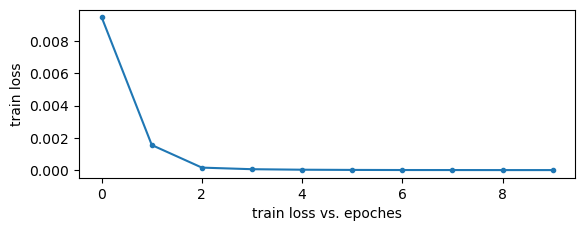

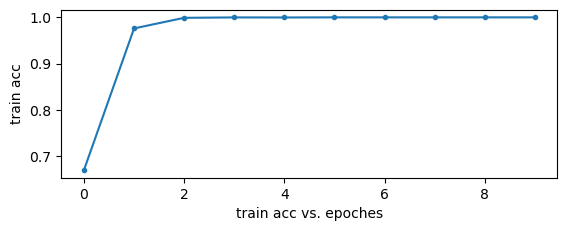

In [9]:
x1 = range(0, epochs)
y1 = Loss_list
# print(y1)
plt.subplot(2, 1, 1)
plt.plot(x1, y1,'.-')
plt.ylabel('train loss')
plt.xlabel('train loss vs. epoches')
plt.show()

x2 = range(0, epochs)
y2 = correct_list
plt.subplot(2, 1, 2)
plt.plot(x2, y2,'.-')
plt.ylabel('train acc')
plt.xlabel('train acc vs. epoches')
plt.show()

In [10]:
train_X1 = torch.from_numpy(train_X).unsqueeze(1).float() 
test_X1 = torch.from_numpy(test_X).unsqueeze(1).float()

y_train = np.load('./datas/train_origin/y_train.npy')
y_test = np.load('./datas/test_origin/y_test.npy')

outputs_X,_ = Net(train_X1)
train_P = outputs_X.detach().numpy() 
# np.save("F_seen_512",train_P)
outputs_X1,_ = Net(test_X1)
test_P = outputs_X1.detach().numpy()
print(train_P.shape)
print(test_P.shape)

(8000, 512)
(8000, 512)


In [11]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
import time

In [12]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_result = tsne.fit_transform(train_P)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.004s...


D:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 8000 samples in 1.883s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 0.662105
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.333290
[t-SNE] KL divergence after 1000 iterations: 0.881726
t-SNE done! Time elapsed: 29.753259420394897 seconds


(8000, 2)
(8000, 1)


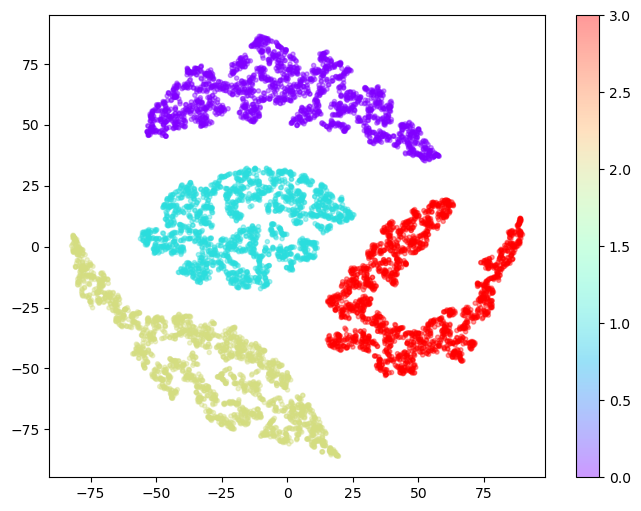

In [13]:
print(tsne_result.shape)
print(y_train.shape)
plt.figure(figsize=(8,6))
plt.scatter(tsne_result[:,0], tsne_result[:,1], c=y_train, alpha=.4, s=3**2, cmap='rainbow')
plt.colorbar()
plt.show()

In [14]:
sns.set()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_result_test = tsne.fit_transform(test_P)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

D:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 8000 samples in 0.006s...
[t-SNE] Computed neighbors for 8000 samples in 1.651s...
[t-SNE] Computed conditional probabilities for sample 1000 / 8000
[t-SNE] Computed conditional probabilities for sample 2000 / 8000
[t-SNE] Computed conditional probabilities for sample 3000 / 8000
[t-SNE] Computed conditional probabilities for sample 4000 / 8000
[t-SNE] Computed conditional probabilities for sample 5000 / 8000
[t-SNE] Computed conditional probabilities for sample 6000 / 8000
[t-SNE] Computed conditional probabilities for sample 7000 / 8000
[t-SNE] Computed conditional probabilities for sample 8000 / 8000
[t-SNE] Mean sigma: 11.186187
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.546257
[t-SNE] KL divergence after 1000 iterations: 1.142491
t-SNE done! Time elapsed: 30.977380990982056 seconds


(8000, 2)
(8000, 1)


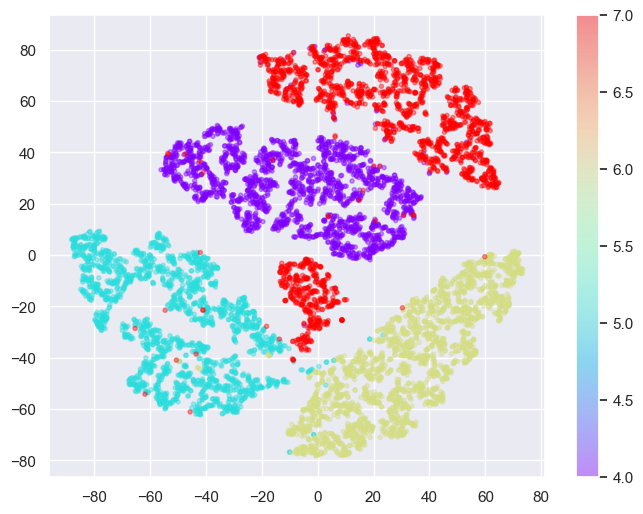

In [15]:
print(tsne_result_test.shape)
print(y_test.shape)
plt.figure(figsize=(8,6))
plt.scatter(tsne_result_test[:,0], tsne_result_test[:,1], c=y_test, alpha=.4, s=3**2, cmap='rainbow')
plt.colorbar()
plt.show()

In [16]:
num = 2000
y=[]

for i in range(num):
    y.append(0)
for i in range(num, num*2):
    y.append(1)
for i in range(num*2, num*3):
    y.append(2)
for i in range(num*3, num*4):
    y.append(3)
for i in range(num*4, num*5):
    y.append(4)
for i in range(num*5, num*6):
    y.append(5)
for i in range(num*6, num*7):
    y.append(6)
for i in range(num*7, num*8):
    y.append(7)

y = np.vstack(y)
print(y.shape)

(16000, 1)


In [17]:
x = []
x.append(train_P)
x.append(test_P)
x = np.vstack(x)
print(np.array(x).shape)

(16000, 512)


In [18]:
sns.set()
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1)
tsne_result_test = tsne.fit_transform(x)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time() - time_start))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 16000 samples in 0.009s...


D:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
D:\anaconda\envs\pytorch\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computed neighbors for 16000 samples in 7.164s...
[t-SNE] Computed conditional probabilities for sample 1000 / 16000
[t-SNE] Computed conditional probabilities for sample 2000 / 16000
[t-SNE] Computed conditional probabilities for sample 3000 / 16000
[t-SNE] Computed conditional probabilities for sample 4000 / 16000
[t-SNE] Computed conditional probabilities for sample 5000 / 16000
[t-SNE] Computed conditional probabilities for sample 6000 / 16000
[t-SNE] Computed conditional probabilities for sample 7000 / 16000
[t-SNE] Computed conditional probabilities for sample 8000 / 16000
[t-SNE] Computed conditional probabilities for sample 9000 / 16000
[t-SNE] Computed conditional probabilities for sample 10000 / 16000
[t-SNE] Computed conditional probabilities for sample 11000 / 16000
[t-SNE] Computed conditional probabilities for sample 12000 / 16000
[t-SNE] Computed conditional probabilities for sample 13000 / 16000
[t-SNE] Computed conditional probabilities for sample 14000 / 16000

(16000, 2)


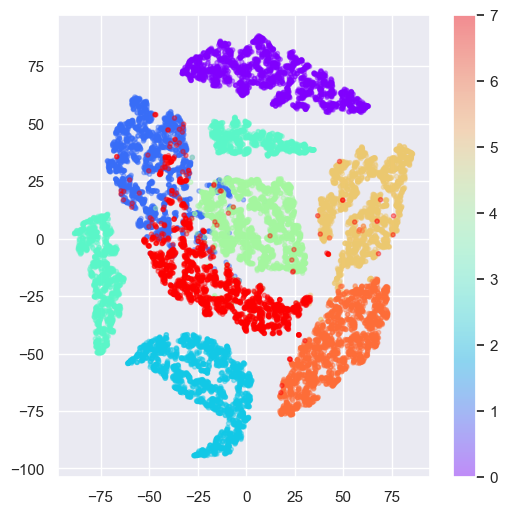

In [19]:
print(tsne_result_test.shape)
plt.figure(figsize=(6,6))
plt.scatter(tsne_result_test[:,0], tsne_result_test[:,1], c=y, alpha=.4, s=3**2, cmap='rainbow')
plt.colorbar()
plt.show()

In [20]:
torch.save(Net.state_dict(), "attention_cnn.pt")
np.save('./datas/features/attention_feature_train_512', train_P)
np.save('./datas/features/attention_feature_test_512', test_P)